# IHLT Project

**Note:** This notebook is the same as the one in code/Results_and_Analysis.ipynb. If one wants to re-execute the code, please refer to that one.

---
---

# Introduction
This project is part of the practical assignment for the course **Introduction to Human Language Technologies (IHLT)** in the **Master in Artificial Intelligence (MAI)** at UPC. The goal is to measure **Semantic Textual Similarity (STS)**, which quantifies the degree of semantic equivalence between two sentences. This assignment is based on **SemEval 2012 Task 6: A Pilot on Semantic Textual Similarity**.

This notebook serves as a general overview of the project, where all the methodology will be explained and the results analyzed. The structure of the notebook is organized as follows:

1. **Feature Explanation**  
2. **Model and Feature Selection**  
3. **Results**  
4. **Feature Analysis**  
5. **Error Analysis**  
6. **Conclusion and Future Work**

It is also relevant to analyse the datasets, as explain in the [SemEval 2012 Task 6 closing paper](https://aclanthology.org/S12-1051.pdf), as we will refer to these characteristics later on in the analysis.


1. **MSRpar (Microsoft Research Paraphrase Corpus):** This dataset consists of pairs of sentences extracted from a large collection of news articles. 

2. **MSRvid (Microsoft Research Video Description Corpus):** The MSRvid dataset contains one-sentence descriptions of short video clips, written by human annotators. Multiple people described the same videos, resulting in sentences that depict the same events but with potential variations in wording and focus. 
3. **SMT-eur (Statistical Machine Translation dataset - Europarl domain):** This dataset includes sentence pairs from machine translation outputs and their corresponding reference translations, specifically from the European Parliament proceedings (Europarl). The pairs involve translating languages such as French to English. Since machine translations can vary in accuracy, the similarity between the machine-generated sentence and the reference translation can range from very high to low. 
4. **SMT-news (Statistical Machine Translation dataset - News domain):** Similar to SMT-eur, the SMT-news dataset comprises sentence pairs of machine translations and reference translations, but sourced from news articles instead of parliamentary proceedings. This introduces different topics and styles inherent to news text. Variations in the quality of machine translations lead to differences in semantic similarity. 
5. **On-WN (OntoNotes and WordNet Gloss Pairs):** The On-WN dataset consists of pairs of glosses—or definitions—from two lexical resources: OntoNotes and WordNet. Each pair includes definitions that may correspond to the same word sense or to different senses altogether

In [24]:
# here are imports we'll use throughout the notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tabulate import tabulate

sns.set_theme(style='whitegrid')

---
---

# 1. Feature Explanation

The assignment required us to analyze three primary dimensions for feature sets: **Lexical**, **Syntactic**, and their combination. However, after thorough research and consideration, we decided to include two additional dimensions: **Semantic** and **Stylistic** features. These dimensions are inherently interconnected, and while categorization can be subjective, we've organized our features to best reflect their core characteristics.

Our work is heavily inspired by the methodologies of the two top-performing teams in the SemEval 2012 Task 6: the **UKP** team and the **TakeLab** team. Below, we detail the features we implemented for each dimension, highlighting any challenges we faced and the approximations we made.

In [25]:
train_csv_path = 'results/train_features.csv'
test_csv_path = 'results/test_features.csv'

train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

lexical_features    = [col for col in train_df.columns if col.startswith('lex_')]
syntactic_features  = [col for col in train_df.columns if col.startswith('syn_')]
semantic_features   = [col for col in train_df.columns if col.startswith('sem_')]
stylistic_features  = [col for col in train_df.columns if col.startswith('sty_')]

combined_features   = lexical_features + syntactic_features + semantic_features + stylistic_features

## 1.1 Lexical Features

Lexical features focus on the surface-level properties of text, such as word choice and string similarities. We implemented a total of **38** lexical features.

### Features Inspired by UKP Team:

- **String-Based Measures**:

  - **Longest Common Substring**: We computed the normalized length of the longest sequence of characters present in both sentences, after removing spaces. This captures shared sequences at the character level.

    - **Implementation Note**: We matched the implementation to the UKP team's description. Normalization was achieved by dividing the length of the longest common substring by the length of the longer sentence, ensuring alignment with their approach.

  - **Longest Common Subsequence**: We calculated the normalized length of the longest sequence of words appearing in the same order in both sentences.

    - **Implementation Note**: We normalized by dividing the length of the longest common subsequence by the length of each sentence, then averaging the two ratios. This accounts for length differences and is consistent with the method described by the UKP team.

  - **Greedy String Tiling**: We implemented a simplified version to measure the total length of matching substrings between the sentences, with a minimum match length of 3.

    - **Approximation**: Our version may be less comprehensive than the UKP's due to simplifications in handling matching substrings, limitations in overlapping tile detection, and computational constraints. We used a basic approach without the full-fledged algorithm to manage resource limitations.

- **Character n-grams**:

  - **Jaccard Similarity of Character n-grams**: For n ranging from 2 to 15, we calculated the Jaccard similarity between sets of character n-grams.

    - **Implementation Note**: We considered the concatenated text without spaces for character n-grams, ensuring consistency in character sequence comparison.

- **Word n-grams**:

  - **Containment and Jaccard Similarities of Word n-grams**: We calculated these similarities for various n-gram sizes, both with and without stopwords.

    - **Specifics**:

      - **Containment Similarity**: For n = 1, 2 (without stopwords). This measure assesses how much one sentence's n-grams are contained within the other.

      - **Jaccard Similarity**:

        - With stopwords: For n = 1, 3, 4.

        - Without stopwords: For n = 2, 4.

      - **Implementation Note**: This follows the configurations mentioned by the UKP team, capturing different aspects of lexical overlap.

- **Edit Distances and Similarities**:

  - **Levenshtein Distance**: We computed the normalized edit distance between the concatenated sentences (without spaces) and converted it into a similarity score.

    - **Implementation Note**: Normalization was achieved by dividing the Levenshtein distance by the length of the longer sentence and subtracting this ratio from 1 to obtain a similarity measure between 0 and 1.

  - **Jaro and Jaro-Winkler Similarities**: We used the `jellyfish` library to compute these similarities between the concatenated sentences (without spaces).

    - **Approximation**: The original implementation details in the UKP system may vary; we ensured our preprocessing (lowercasing and concatenating without spaces) was consistent to approximate their results.

  - **Monge-Elkan Similarity**: This aggregates the maximum similarity scores between words from both sentences, using Jaro-Winkler as the secondary similarity function.

    - **Implementation Note**: This captures the best word-level matches across sentences, consistent with the method described by the UKP team.

### Features Inspired by TakeLab Team:

- **N-gram Overlap Features**:

  - **Unigrams, Bigrams, Trigrams Overlap**: We calculated the overlap of these n-grams, including only content words (i.e., excluding stopwords and punctuation).

    - **Implementation Note**: We used the harmonic mean of the coverage ratios to balance the overlap between the two sentences, as per the TakeLab team's approach.

  - **Skip N-grams**: We computed overlaps for skip bigrams and trigrams, allowing gaps within n-grams.

    - **Approximation**: Our skip n-gram implementation generates all possible combinations of n words in the sentence without considering word order (i.e., unordered skip n-grams). This may not fully align with the TakeLab's method, which could consider specific skip patterns. Due to computational limitations and time constraints, our implementation may not cover all possible skips, especially for longer sentences.

- **WordNet-Augmented Overlap**:

  - We extended word overlaps by considering WordNet synonyms, thus matching words that are semantically related.

    - **Implementation Note**: We computed the WordNet-based coverage (`P_WN`) as described by the TakeLab team, using path similarity between words.

    - **Approximation**: We relied on WordNet path similarity, which may not capture all synonym relationships as comprehensively as more sophisticated measures like Lin's similarity. Additionally, we may have lacked the exact parameter tuning used by the TakeLab team due to resource constraints.

- **Weighted Word Overlap**:

  - Overlaps were weighted by the information content (IC) of words, assigning greater importance to rarer words.

    - **Implementation Note**: IC was calculated based on word frequencies from the Brown corpus, following the TakeLab team's method. This emphasizes the contribution of less frequent, more informative words in the overlap.

In [26]:
display(lexical_features)

['lex_longest_common_substring_norm',
 'lex_longest_common_subsequence_norm',
 'lex_greedy_string_tiling',
 'lex_char_2gram_jaccard',
 'lex_char_3gram_jaccard',
 'lex_char_4gram_jaccard',
 'lex_char_5gram_jaccard',
 'lex_char_6gram_jaccard',
 'lex_char_7gram_jaccard',
 'lex_char_8gram_jaccard',
 'lex_char_9gram_jaccard',
 'lex_char_10gram_jaccard',
 'lex_char_11gram_jaccard',
 'lex_char_12gram_jaccard',
 'lex_char_13gram_jaccard',
 'lex_char_14gram_jaccard',
 'lex_char_15gram_jaccard',
 'lex_word_1gram_containment_no_stop',
 'lex_word_2gram_containment_no_stop',
 'lex_word_1gram_jaccard',
 'lex_word_3gram_jaccard',
 'lex_word_4gram_jaccard',
 'lex_word_2gram_jaccard_no_stop',
 'lex_word_4gram_jaccard_no_stop',
 'lex_levenshtein_normalized',
 'lex_jaro_similarity',
 'lex_jaro_winkler_similarity',
 'lex_monge_elkan_similarity',
 'lex_ngram_overlap_1',
 'lex_ngram_overlap_2',
 'lex_ngram_overlap_3',
 'lex_content_ngram_overlap_1',
 'lex_content_ngram_overlap_2',
 'lex_content_ngram_overla

## 1.2 Syntactic Features

Syntactic features capture grammatical structures and relationships within the text. We implemented a total of **18** syntactic features.

### Features Inspired by UKP Team:

- **Stopword n-grams**:

  - We computed the containment similarity of stopword sequences for n ranging from 2 to 10.

    - **Implementation Note**: This helps detect similar function word patterns and sentence structures, as function words often reflect the grammatical backbone of sentences.

- **POS n-grams**:

  - We calculated Jaccard similarities of sequences of Part-of-Speech (POS) tags for n = 2, 3, 4.

    - **Implementation Note**: POS tagging was done using NLTK's `pos_tag` function, which may differ from the tools used by the UKP team. This feature captures similarities in grammatical patterns between sentences.

- **Word Pair Order and Distance**:

  - **Word Pair Order**: Measures the proportion of word pairs that appear in the same order in both sentences, considering all possible word pairs from each sentence.

    - **Implementation Note**: We generated all possible word pairs within each sentence and counted the number of pairs common to both sentences.

    - **Approximation**: Due to computational constraints, we did not optimize for efficiency and considered all word pairs without pruning, which may differ from the UKP's implementation.

  - **Word Pair Distance**: Assesses how the positions of shared words differ between sentences.

    - **Implementation Note**: We calculated the average positional difference for shared words and converted it into a similarity score using a transformation to ensure it falls between 0 and 1.

### Features Inspired by TakeLab Team:

- **Syntactic Roles Similarity**:

  - Extracted syntactic roles (subjects, objects, predicates) using spaCy and computed similarities using WordNet-based semantic similarity.

    - **Implementation Note**: For each role, we extracted relevant tokens and computed the maximum WordNet similarity between the tokens of that role in both sentences.

    - **Approximation**: Our method may not fully capture the depth of the original TakeLab team's approach. In their system, they align predicate groups and compute aggregated similarities, including chunk-level similarities and alignment of multiple predicates. Due to time and resource constraints, we simplified this by focusing on maximum similarities for each role without complex alignment strategies.

- **Syntactic Dependencies Overlap**:

  - We extracted dependency relations (dependency label, head lemma, dependent lemma) and calculated overlaps.

    - **Implementation Note**: Overlaps were computed based on matching dependency triples and combined using the harmonic mean to balance differences in sentence lengths, similar to the approach in the TakeLab paper.

    - **Approximation**: Our dependency parsing was performed using spaCy, which may differ from the parsers used by TakeLab (e.g., Stanford Parser). Consequently, the granularity and accuracy of dependency relations may vary, potentially affecting the overlap calculations.

In [27]:
display(syntactic_features)

['syn_stopword_ngram_overlap_2',
 'syn_stopword_ngram_overlap_3',
 'syn_stopword_ngram_overlap_4',
 'syn_stopword_ngram_overlap_5',
 'syn_stopword_ngram_overlap_6',
 'syn_stopword_ngram_overlap_7',
 'syn_stopword_ngram_overlap_8',
 'syn_stopword_ngram_overlap_9',
 'syn_stopword_ngram_overlap_10',
 'syn_pos_2gram_jaccard',
 'syn_pos_3gram_jaccard',
 'syn_pos_4gram_jaccard',
 'syn_word_pair_order',
 'syn_word_pair_distance',
 'syn_syntactic_similarity_subject',
 'syn_syntactic_similarity_object',
 'syn_syntactic_similarity_predicate',
 'syn_dependency_overlap']

## 1.3 Semantic Features

Semantic features delve into the meanings of words and sentences. We implemented a total of **28** semantic features.

### Features Inspired by UKP Team:

- **Pairwise Word Similarity**:

  - **Resnik Similarity**: Calculated average semantic similarities between words using Resnik's measure, based on WordNet and the Brown corpus for information content.

    - **Implementation Note**: Only nouns and verbs were considered, aligning with the standard use of Resnik's measure and the approach described by the UKP team.

    - **Approximation**: Due to computational constraints, we did not consider adjectives and adverbs, which may limit the comprehensiveness of the measure compared to the original UKP implementation.

- **Explicit Semantic Analysis (ESA)**:

  - Represented sentences in a high-dimensional concept space derived from Wikipedia and computed cosine similarities.

    - **Implementation Note**: We built the ESA model using 300,000 articles from Wikipedia to construct the term-concept matrix.

    - **Approximation**:

      - **Corpus Size**: Unlike the UKP team, which likely used the full Wikipedia corpus, we limited our model to a subset due to resource constraints, potentially affecting the richness and coverage of the concept space.

      - **Processing Simplifications**: Our ESA index may be less comprehensive and possibly less optimized, impacting the accuracy of the similarity scores.

- **Lexical Substitution**:

  - Enriched sentences with synonyms from WordNet for content words to enhance matching opportunities.

    - **Implementation Note**: We performed lexical substitution for about 1,000 frequent English nouns, similar to the UKP team's approach.

    - **Approximation**:

      - **Simplified Substitutions**: Our approach uses basic synonym extraction without considering word sense disambiguation, meaning context-specific substitutions may not be accurate.

      - **Frequency Constraints**: We limited substitutions to frequent nouns to manage computational load, potentially missing substitutions for verbs and less frequent words.

- **Statistical Machine Translation (SMT) Back-Translation**:

  - Translated sentences to intermediate languages and back to English using `deep_translator` to generate paraphrases.

    - **Implementation Note**: We used German, Spanish, and Dutch as intermediate languages.

    - **Approximation**:

      - **Translation Tools**: Unlike the UKP team, which used the Moses SMT system trained on Europarl data, we used the `deep_translator` library accessing online translation services, which may not produce translations of comparable quality or consistency.

      - **Limited Languages**: Due to API limitations and resource constraints, we used only a few bridge languages, possibly reducing the diversity of paraphrases generated.

- **Distributional Thesaurus**:

  - Built a co-occurrence matrix from the Brown corpus focusing on cardinal numbers and computed similarities.

    - **Implementation Note**: We constructed a co-occurrence matrix exclusively for cardinal numbers (POS tag 'CD'), capturing their distributional properties.

    - **Approximation**:

      - **Scope Limitation**: By focusing only on cardinal numbers, we significantly simplified the model, which may not capture broader semantic relationships.

      - **Data Constraints**: The Brown corpus is relatively small compared to corpora used in advanced distributional models, limiting the reliability and coverage of the computed similarities.

### Features Inspired by TakeLab Team:

- **Greedy Lemma Alignment Overlap**:

  - Performed greedy alignment of lemmas between sentences using WordNet similarity, weighted by information content.

    - **Implementation Note**: We aligned lemmas by repeatedly selecting pairs with the highest WordNet similarity, excluding aligned lemmas from further consideration, and weighted the similarities by the higher information content of the two lemmas.

    - **Approximation**: While we followed the general approach described by the TakeLab team, we used Resnik's measure for WordNet similarity and may not have replicated their exact method or parameter settings.

- **Numbers Overlap**:

  - Compared numerical expressions between sentences, computing overlap scores.

    - **Implementation Note**: We extracted numbers from sentences and calculated the harmonic mean of the coverage ratios to assess the similarity in quantitative information.

    - **Approximation**: We considered numbers as exact matches, without handling approximate matches or numeric similarity (e.g., "65" vs. "65.2"), which may not capture nuanced quantitative relationships as effectively as the original TakeLab approach.

- **Named Entity Features**:

  - Extracted named entities using spaCy and evaluated overlaps and mismatches.

    - **Implementation Note**: Overlaps were calculated overall and for specific entity types (e.g., PERSON, ORG). We also included features indicating the absence of certain entity types in both sentences.

    - **Approximation**: The accuracy depends on spaCy's named entity recognition (NER), which may differ from the tools used by the TakeLab team (e.g., OpenNLP). Differences in NER performance and entity type definitions could affect the feature's effectiveness.

- **Normalized Differences**:

  - Assessed differences in sentence lengths and aggregate information content, normalized appropriately.

    - **Implementation Note**: Differences were calculated and normalized by the average of the two sentences to account for varying sentence lengths and to provide a scale-independent measure.


In [28]:
display(semantic_features)

['sem_avg_word_similarity',
 'sem_esa_similarity',
 'sem_avg_word_similarity_lexsub',
 'sem_avg_word_similarity_smt',
 'sem_dt_similarity_cardinal_numbers',
 'sem_greedy_lemma_align_overlap',
 'sem_numbers_overlap',
 'sem_named_entity_overlap',
 'sem_named_entity_overlap_PERSON',
 'sem_named_entity_overlap_DATE',
 'sem_named_entity_overlap_CARDINAL',
 'sem_length_difference',
 'sem_information_content_difference',
 'sem_named_entity_overlap_ORG',
 'sem_named_entity_overlap_ORDINAL',
 'sem_named_entity_overlap_NORP',
 'sem_named_entity_overlap_LOC',
 'sem_named_entity_overlap_PERCENT',
 'sem_named_entity_overlap_MONEY',
 'sem_named_entity_overlap_GPE',
 'sem_named_entity_overlap_TIME',
 'sem_named_entity_overlap_PRODUCT',
 'sem_named_entity_overlap_WORK_OF_ART',
 'sem_named_entity_overlap_FAC',
 'sem_named_entity_overlap_LAW',
 'sem_named_entity_overlap_QUANTITY',
 'sem_named_entity_overlap_EVENT',
 'sem_named_entity_overlap_LANGUAGE']

## 1.4 Stylistic Features

Stylistic features capture aspects of writing style and tone. We implemented **3** stylistic features.

### Features Inspired by UKP Team:

- **Function Word Frequencies**:

  - Computed the Pearson correlation between frequencies of function words in both sentences.

    - **Implementation Note**: We handled cases with insufficient data (e.g., too few function words or zero variance) by defaulting the correlation to zero, ensuring robustness and preventing computational errors.

- **Type-Token Ratio (TTR)**:

  - Measured lexical diversity by calculating the ratio of unique words to total words in each sentence.

    - **Implementation Note**: This provides insight into the vocabulary richness of sentences, which can be indicative of stylistic similarity.

- **Sequential TTR**:

  - Computed TTR over sliding windows (size 20) to capture lexical diversity throughout the sentences.

    - **Implementation Note**: We averaged the TTRs of all windows to obtain a comprehensive measure that reflects variations in lexical diversity across different parts of the sentences.

In [29]:
display(stylistic_features)

['sty_function_word_freq_similarity',
 'sty_ttr_difference',
 'sty_sttr_difference']

## 1.5 Combined Features

We finally combined **Lexical**, **Syntactic**, **Semantic**, and **Stylistic** features into unified feature sets. Of these we have **87**.

In [30]:
display(combined_features)

['lex_longest_common_substring_norm',
 'lex_longest_common_subsequence_norm',
 'lex_greedy_string_tiling',
 'lex_char_2gram_jaccard',
 'lex_char_3gram_jaccard',
 'lex_char_4gram_jaccard',
 'lex_char_5gram_jaccard',
 'lex_char_6gram_jaccard',
 'lex_char_7gram_jaccard',
 'lex_char_8gram_jaccard',
 'lex_char_9gram_jaccard',
 'lex_char_10gram_jaccard',
 'lex_char_11gram_jaccard',
 'lex_char_12gram_jaccard',
 'lex_char_13gram_jaccard',
 'lex_char_14gram_jaccard',
 'lex_char_15gram_jaccard',
 'lex_word_1gram_containment_no_stop',
 'lex_word_2gram_containment_no_stop',
 'lex_word_1gram_jaccard',
 'lex_word_3gram_jaccard',
 'lex_word_4gram_jaccard',
 'lex_word_2gram_jaccard_no_stop',
 'lex_word_4gram_jaccard_no_stop',
 'lex_levenshtein_normalized',
 'lex_jaro_similarity',
 'lex_jaro_winkler_similarity',
 'lex_monge_elkan_similarity',
 'lex_ngram_overlap_1',
 'lex_ngram_overlap_2',
 'lex_ngram_overlap_3',
 'lex_content_ngram_overlap_1',
 'lex_content_ngram_overlap_2',
 'lex_content_ngram_overla

In conclusion, while we did our best to replicate the features from the UKP and TakeLab teams accurately, we faced certain limitations:

- **Resource Constraints**: Building models like ESA using the full Wikipedia corpus and performing extensive data processing were not feasible, so we limited our dataset to a subset and simplified computations.

- **Computational Limitations**: Some algorithms were simplified or approximated to manage computation times and resource usage (e.g., Greedy String Tiling, skip n-grams, exhaustive word pair comparisons).

- **Tool Accessibility**: We used readily available tools (e.g., NLTK, spaCy, `deep_translator`) which might differ in performance and capabilities from those used by the original teams (e.g., specialized WSD systems, Moses SMT, Stanford Parser), potentially affecting feature accuracy.

- **Simplifications in Feature Implementation**: Due to time and knowledge constraints, we may not have fully captured the complexities of some features (e.g., detailed syntactic role alignment, nuanced named entity handling), leading to approximations.

---
---

# 2. Model and Feature Selection

We explored three regression models for predicting semantic textual similarity:

- **Gradient Boosting Regressor (GBR)**
- **Random Forest Regressor (RFR)**
- **Support Vector Regressor (SVR)**

These models were chosen for their ability to capture non-linear relationships and robustness in handling complex feature interactions.

## 2.1 Experimental Procedure

### 2.1.1 Data Preparation

- Handling Missing Values: Addressed missing data in features, such as "sem_named_entity_overlap_EVENT" when no event tags were present in either sentence.
   - Outlier Mitigation: Clipped extreme feature values to address anomalies due to limited training corpora (e.g., Brown Corpus, 300,000 Wikipedia articles). We tuned this manually before experimentation, on a small cross-validation over a few models.
   - Feature Standardization: Standardized features using `RobustScaler`. We tuned this manually before experimentation, on a small cross-validation over a few models.

### 2.1.2 Model Training and Selection

#### Cross-Validation and Grid Search
- Conducted **5-fold cross-validation** using `GridSearchCV`, which included hyperparameter tuning for each algorithm.
- Integrated **Recursive Feature Elimination (RFE)** within the cross-validation process. During each fold:
  - RFE was applied to select the most relevant features.
  - Evaluated subsets of features from 20 up to the total number of features (or 100 features), in increments of 10.

#### 2.1.3 Model Evaluation
- Evaluated models based on the **Pearson Correlation Coefficient** obtained during cross-validation.
- Selected the model with the highest cross-validation Pearson correlation as the best model for each feature set.


**Note:** When training the model with all the features combined, we made a mistake and forgot to include the stylistic features. Unfortunately we did not have enough time to re-execute the experiments as it took around 40h to do so and we already the full analysis; nevertheless, there were only 3 stylistic features, and they consistently showed to be the less important onces, so we believe this does not really impact our project.

---
---


# 3. Results
In this section, we analyze the performance of our models across different feature sets and compare our results with those of the top-performing teams in the SemEval 2012 Task 6 competition. We also visualize the results to better understand the effectiveness of each feature set and model.

Note: We always train our model on the whole dataset, and we do not know, when predicting, what dataset we are working on.

## 3.1 Loading and Preparing Results
First, we load the results from our experiments into a DataFrame for analysis.

In [31]:
results_csv_path = 'results/model_results.csv'
results_df = pd.read_csv(results_csv_path)

## 3.2 Overall Performance Analysis
Let's analyze the overall performance of our models across different feature sets.

In [32]:
overall_metrics = results_df[['Feature_Set', 'Model_Name', 'Test_Pearson', 'Test_RMSE', 'Test_MAE', 'Test_R2']]
overall_metrics

,Feature_Set,Model_Name,Test_Pearson,Test_RMSE,Test_MAE,Test_R2
0,lexical,GradientBoosting,0.744390,1.006862,0.777983,0.460417
1,lexical,RandomForest,0.735264,1.021530,0.787713,0.444582
2,lexical,SVR,0.734798,1.022289,0.789522,0.443755
3,syntactic,GradientBoosting,0.629673,1.204421,0.934248,0.227897
4,syntactic,RandomForest,0.641274,1.169229,0.938591,0.272359
5,syntactic,SVR,0.576610,1.313904,1.020762,0.081148
6,semantic,GradientBoosting,0.585304,1.242675,0.974908,0.178073
7,semantic,RandomForest,0.570938,1.198577,0.998543,0.235372
8,semantic,SVR,0.550074,1.261718,0.994410,0.152689
9,stylistic,GradientBoosting,0.189605,1.513894,1.286176,-0.219858


We identify the best-performing model for each feature set based on the highest Pearson correlation.

In [33]:
best_models = results_df.sort_values('Test_Pearson', ascending=False).groupby('Feature_Set').head(1)
best_models_overall = best_models[['Feature_Set', 'Model_Name', 'Test_Pearson', 'Test_RMSE', 'Test_MAE', 'Test_R2']]
display(best_models_overall)

,Feature_Set,Model_Name,Test_Pearson,Test_RMSE,Test_MAE,Test_R2
12,combined,GradientBoosting,0.763381,0.988437,0.767143,0.479985
0,lexical,GradientBoosting,0.744390,1.006862,0.777983,0.460417
4,syntactic,RandomForest,0.641274,1.169229,0.938591,0.272359
6,semantic,GradientBoosting,0.585304,1.242675,0.974908,0.178073
9,stylistic,GradientBoosting,0.189605,1.513894,1.286176,-0.219858


We can visualize the Pearson correlation achieved by each model for each feature set.

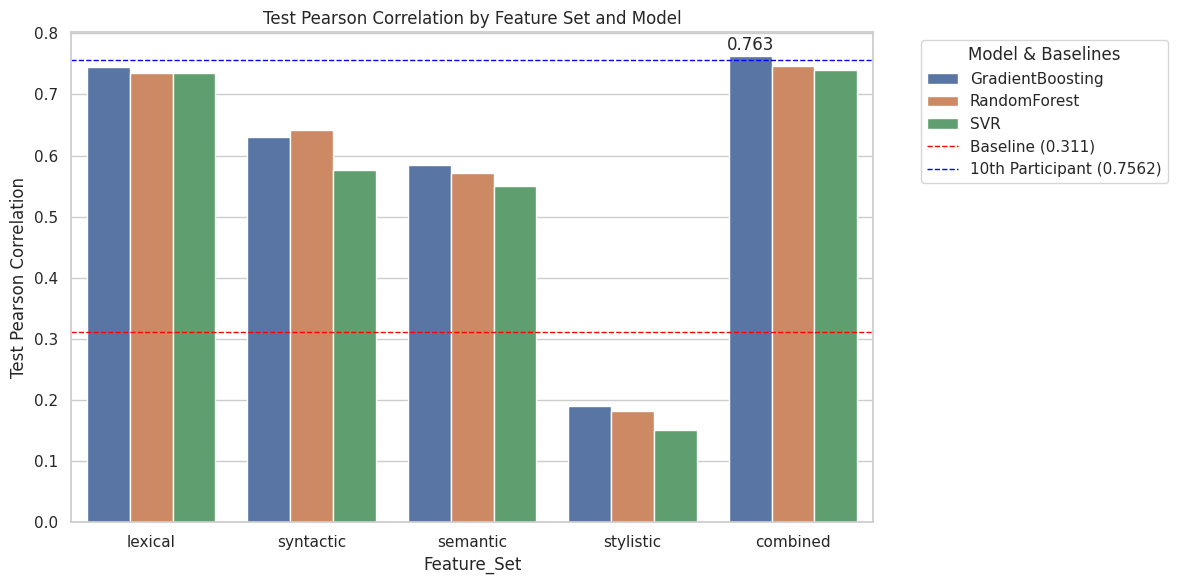

In [34]:
plt.figure(figsize=(12, 6))

barplot = sns.barplot(x='Feature_Set', y='Test_Pearson', hue='Model_Name', data=results_df)

# annotate
for p in barplot.patches:
    if p.get_height() > 0.7562: # if above 10th participant!
        barplot.annotate(format(p.get_height(), '.3f'), 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='center', 
                        xytext=(0, 8), 
                        textcoords='offset points')

# horizontal lines for baseline and top 10
plt.axhline(y=0.311, color='red', linestyle='--', linewidth=1, label='Baseline (0.311)')
plt.axhline(y=0.7562, color='blue', linestyle='--', linewidth=1, label='10th Participant (0.7562)')

plt.title('Test Pearson Correlation by Feature Set and Model')
plt.ylabel('Test Pearson Correlation')

handles, labels = barplot.get_legend_handles_labels()

plt.legend(handles, labels, title='Model & Baselines', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

os.makedirs("results/figures", exist_ok=True)

output_path = "results/figures/Test_Pearson_Correlation_by_Feature_Set_and_Model.png"
plt.savefig(output_path, dpi=300)

plt.show()


In [35]:
# also as a table
table_data = results_df.pivot(index='Feature_Set', columns='Model_Name', values='Test_Pearson')
table_data = table_data.round(3)
print(tabulate(table_data, headers='keys', tablefmt='pretty'))

+-------------+------------------+--------------+-------+
| Feature_Set | GradientBoosting | RandomForest |  SVR  |
+-------------+------------------+--------------+-------+
|  combined   |      0.763       |    0.746     | 0.74  |
|   lexical   |      0.744       |    0.735     | 0.735 |
|  semantic   |      0.585       |    0.571     | 0.55  |
|  stylistic  |       0.19       |    0.182     | 0.151 |
|  syntactic  |       0.63       |    0.641     | 0.577 |
+-------------+------------------+--------------+-------+


**Analysis:**

Most of the predictive "weight" seems to be on the lexical features, with them standalone almost breaking into the top 10. We see a decay as we progress with syntactic, semantic, and stylistic features, with the latter not even being able to break the baseline. All of this suggests that the lexical dimension is the most important; nevertheless, we achieve the best performance when combining all feature sets, indicating that there is some aspect of the problem lexical features alone can not capture.

Throughout, GradientBoosting is the best model, except with syntactic features, where RandomForest works better. 

We achieve a pearson accuracy on the test set above the 10th participant only when combining all the features and using GradientBoosting.

## 3.2 Per-Dataset Performance Analysis

Now, let's analyze the per-dataset Pearson correlations, but only for the best models per feature set.

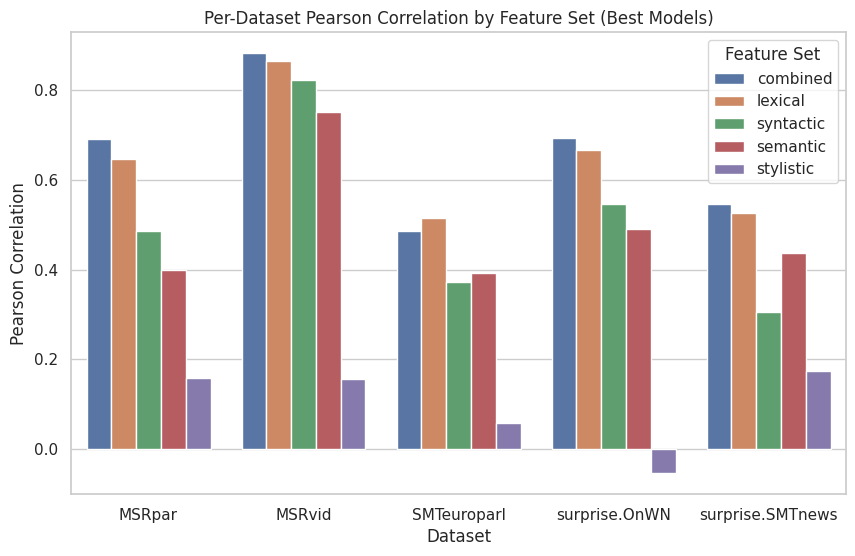

In [36]:
per_dataset_cols = [col for col in best_models.columns if col.startswith('Pearson_')]
per_dataset_results = best_models.melt(id_vars=['Feature_Set'], value_vars=per_dataset_cols, var_name='Dataset', value_name='Pearson')
per_dataset_results['Dataset'] = per_dataset_results['Dataset'].str.replace('Pearson_', '')
per_dataset_results[['Feature_Set', 'Dataset', 'Pearson']]

plt.figure(figsize=(10, 6))
sns.barplot(x='Dataset', y='Pearson', hue='Feature_Set', data=per_dataset_results)
plt.title('Per-Dataset Pearson Correlation by Feature Set (Best Models)')
plt.ylabel('Pearson Correlation')
plt.xlabel('Dataset')
plt.legend(title='Feature Set')

output_path = "results/figures/Per-Dataset_Pearson_Correlation_by_Feature_Set_(Best_Models).png"
plt.savefig(output_path, dpi=300)

plt.show()


In [37]:
# as a table too
per_dataset_cols = [col for col in best_models.columns if col.startswith('Pearson_')]
per_dataset_results = best_models.melt(
    id_vars=['Feature_Set'],
    value_vars=per_dataset_cols,
    var_name='Dataset',
    value_name='Pearson'
)
per_dataset_results['Dataset'] = per_dataset_results['Dataset'].str.replace('Pearson_', '')
pivot_table = per_dataset_results.pivot(index='Dataset', columns='Feature_Set', values='Pearson')
pivot_table = pivot_table.round(3)
print(tabulate(pivot_table, headers='keys', tablefmt='pretty'))

+------------------+----------+---------+----------+-----------+-----------+
|     Dataset      | combined | lexical | semantic | stylistic | syntactic |
+------------------+----------+---------+----------+-----------+-----------+
|      MSRpar      |   0.69   |  0.646  |  0.399   |   0.158   |   0.486   |
|      MSRvid      |  0.882   |  0.864  |  0.751   |   0.157   |   0.823   |
|   SMTeuroparl    |  0.486   |  0.515  |  0.393   |   0.059   |   0.373   |
|  surprise.OnWN   |  0.693   |  0.666  |  0.491   |  -0.053   |   0.546   |
| surprise.SMTnews |  0.547   |  0.525  |  0.437   |   0.174   |   0.306   |
+------------------+----------+---------+----------+-----------+-----------+


### **Analysis:**

**MSRpar Dataset:** Moderate correlations were observed, with combined features at **0.690** and lexical features at **0.646**, reflecting less lexical overlap and more complex paraphrasing. Syntactic (**0.486**) and semantic (**0.399**) features contributed modestly, while stylistic features had minimal impact (**0.158**).

**MSRvid Dataset:** Combined features achieved the highest Pearson correlation (**0.882**), with lexical features close behind (**0.864**). This indicates strong reliance on surface-level lexical overlap. Syntactic (**0.823**) and semantic (**0.751**) features also performed well, capturing structural and meaning-based similarities. Stylistic features, however, contributed minimally (**0.157**), underscoring the importance of content over style.

**SMTeuroparl Dataset:** Correlations were generally lower, with combined features at **0.486** and lexical features at **0.515**. Semantic (**0.393**) and syntactic (**0.373**) features contributed similarly but less effectively than lexical features, while stylistic features added little (**0.059**). Lower performance suggests domain-specific language and less direct lexical overlap.

**surprise.OnWN Dataset:** Combined features reached **0.693**, with lexical features trailing slightly at **0.666**. Syntactic (**0.546**) and semantic (**0.491**) features demonstrated moderate performance. Stylistic features had a negative correlation (**-0.053**), suggesting that stylistic diversity may inversely relate to semantic similarity due to varied writing styles like WordNet definitions.

**surprise.SMTnews Dataset:** Moderate performance was seen with combined features (**0.547**) and lexical features (**0.525**). Semantic features (**0.437**) outperformed syntactic features (**0.306**), indicating greater importance of meaning-based features. Stylistic features contributed minimally (**0.174**).

#### Importance of Feature Types

Lexical features were crucial across all datasets, performing best in cases with high lexical overlap (e.g., MSRvid) but showing limitations in datasets with less surface similarity (e.g., SMTeuroparl). Semantic features captured deeper meaning relations, proving especially useful in datasets like surprise.SMTnews (**0.437**), where wording differed significantly. Syntactic features offered additional insights, particularly in datasets like MSRvid and MSRpar, though they struggled with more varied syntax. Stylistic features consistently showed low correlations, with a negative relationship in surprise.OnWN (**-0.053**), suggesting they are not reliable indicators of semantic similarity.

The consistent improvement in performance with combined features highlights their complementary nature. Datasets with moderate individual feature performance, like surprise.OnWN and surprise.SMTnews, benefited most from combined approaches, which integrated lexical, syntactic, and semantic information to capture diverse aspects of similarity.

#### Dataset Characteristics Affecting Performance

MSRvid’s short video captions, with high lexical overlap and simple syntax, explain the dominance of lexical features. MSRpar’s more complex paraphrases reduced lexical effectiveness, requiring support from syntactic and semantic features. surprise.OnWN, based on WordNet definitions, emphasized semantic nuances due to pronounced stylistic differences. SMTeuroparl and surprise.SMTnews, involving machine translation outputs and news texts, respectively, posed challenges with domain-specific language and unpredictable paraphrasing patterns.

## 3.3 Comparison against official results

Given our results, we would *just* make the top 10 of the rankings; let's compute where we would be in a simulated ranking based on the [official results](https://aclanthology.org/S12-1051.pdf). Note we do not compute the normalised pearson, so we omit the column.

In [38]:
# get best model
best_model = results_df.loc[results_df['Test_Pearson'].idxmax()]
best_model_data = best_model[["Test_Pearson", "Pearson_MSRpar", "Pearson_MSRvid", "Pearson_SMTeuroparl", "Pearson_surprise.OnWN", "Pearson_surprise.SMTnews"]]

# compute the (weighted) mean pearson too
dataset_sizes = {"Pearson_MSRpar": 750, "Pearson_MSRvid": 750, "Pearson_surprise.OnWN": 750, "Pearson_SMTeuroparl": 459, "Pearson_surprise.SMTnews": 399}
pearson_scores = best_model[["Pearson_MSRpar", "Pearson_MSRvid", "Pearson_surprise.OnWN", "Pearson_SMTeuroparl", "Pearson_surprise.SMTnews"]]
weighted_mean_pearson = sum(pearson_scores[dataset] * size for dataset, size in dataset_sizes.items()) / sum(dataset_sizes.values())


# relevant data:
headers = [
    "Run", "ALL", "Rank", "ALLnrm", "Rank", "Mean", "Rank",
    "MSRpar", "MSRvid", "SMT-eur", "On-WN", "SMT-news"
]

data = [
    ["baer/task6-UKP-run2 plus postprocessing smt twsi" , 0.8239, 1, 0.8579, 2, 0.6773, 2, 0.6830, 0.8739, 0.5280, 0.6641, 0.4937],
    ["jan snajder/task6-takelab-syntax"                 , 0.8138, 2, 0.8569, 3, 0.6601, 6, 0.6985, 0.8620, 0.3612, 0.7049, 0.4683],
    ["jan snajder/task6-takelab-simple"                 , 0.8133, 3, 0.8635, 1, 0.6753, 3, 0.7343, 0.8803, 0.4771, 0.6797, 0.3989],
    ["baer/task6-UKP-run1"                              , 0.8117, 4, 0.8559, 4, 0.6708, 5, 0.6821, 0.8708, 0.5118, 0.6649, 0.4672],
    ["rada/task6-UNT-IndividualRegression"              , 0.7846, 5, 0.8440, 6, 0.6162, 14, 0.5353, 0.8750, 0.4203, 0.6715, 0.4033],
    ["mheilman/task6-ETS-PERPphrases"                   , 0.7834, 6, 0.8089, 27, 0.6399, 8, 0.6397, 0.7200, 0.4850, 0.7124, 0.5312],
    ["mheilman/task6-ETS-PERP"                          , 0.7808, 7, 0.8064, 32, 0.6305, 12, 0.6211, 0.7210, 0.4722, 0.7080, 0.5149],
    ["baer/task6-UKP-run3 plus random"                  , 0.7790, 8, 0.8166, 19, 0.4320, 72, 0.6830, 0.8739, 0.5280, -0.0620, -0.0520],
    ["rada/task6-UNT-IndividualDecTree"                 , 0.7677, 9, 0.8389, 9, 0.5947, 26, 0.5693, 0.8688, 0.4203, 0.6491, 0.2256],
    ["yeh/task6-SRIUBC-SYSTEM2†"                        , 0.7562, 11, 0.8111, 24, 0.5858, 34, 0.6050, 0.7939, 0.4294, 0.5871, 0.3366]
]

our_results = [
    "**Our_Results**",
    round(best_model["Test_Pearson"], 4),
    "**10**",
    "-",
    "-",
    round(weighted_mean_pearson, 4),
    "**1**",
    round(best_model["Pearson_MSRpar"], 4),
    round(best_model["Pearson_MSRvid"], 4),
    round(best_model["Pearson_SMTeuroparl"], 4),
    round(best_model["Pearson_surprise.OnWN"], 4),
    round(best_model["Pearson_surprise.SMTnews"], 4)
]

df = pd.DataFrame(data, columns=headers)
df.loc[len(df)] = our_results

# re-index
df["ALL"] = pd.to_numeric(df["ALL"], errors="coerce")  # Ensure numeric sorting
df = df.sort_values(by="ALL", ascending=False).reset_index(drop=True)

pretty_table = tabulate(df, headers="keys", tablefmt="pretty")
print(pretty_table)

+----+--------------------------------------------------+--------+--------+--------+------+--------+-------+--------+--------+---------+--------+----------+
|    |                       Run                        |  ALL   |  Rank  | ALLnrm | Rank |  Mean  | Rank  | MSRpar | MSRvid | SMT-eur | On-WN  | SMT-news |
+----+--------------------------------------------------+--------+--------+--------+------+--------+-------+--------+--------+---------+--------+----------+
| 0  | baer/task6-UKP-run2 plus postprocessing smt twsi | 0.8239 |   1    | 0.8579 |  2   | 0.6773 |   2   | 0.683  | 0.8739 |  0.528  | 0.6641 |  0.4937  |
| 1  |         jan snajder/task6-takelab-syntax         | 0.8138 |   2    | 0.8569 |  3   | 0.6601 |   6   | 0.6985 | 0.862  | 0.3612  | 0.7049 |  0.4683  |
| 2  |         jan snajder/task6-takelab-simple         | 0.8133 |   3    | 0.8635 |  1   | 0.6753 |   3   | 0.7343 | 0.8803 | 0.4771  | 0.6797 |  0.3989  |
| 3  |               baer/task6-UKP-run1                | 

^note: the above rankings have been re-computed taking into account our results.

### **Analysis:**

Our model achieved an overall Pearson correlation of 0.7634, placing us at 10th position in the simulated rankings. Importantly, we attained the highest mean rank among all participants, indicating that our model consistently performed well across all datasets, rather than excelling in just a few.

Comparatively, while teams like UKP and TakeLab secured higher overall correlations (0.8239 and 0.8138 respectively), their mean ranks were lower. For instance, UKP had a mean rank of 2, and TakeLab's syntax model had a mean rank of 6. This suggests that although their models achieved high performance on some datasets, their results were less consistent across all datasets compared to ours.

On the MSRvid dataset, our model achieved a Pearson correlation of 0.8817, outperforming all other submissions, including UKP's top result of 0.8739 and TakeLab's 0.8803. Regarding the MSRpar dataset, our model achieved a correlation of 0.6900, which is competitive with the top teams. UKP's best run had a correlation of 0.6830, and TakeLab's best was 0.7343. Although TakeLab slightly outperformed us on MSRpar, our results are still among the top. In the SMT-eur dataset, we achieved a Pearson correlation of 0.4861, which is close to UKP's 0.5280 and exceeds TakeLab's 0.4771. 

Regarding the surprise datasets, in the On-WN dataset, our correlation of 0.6926 surpassed several top competitors, including SRIUBC's 0.5871 and UNT's 0.6715. For the SMT-news dataset, we achieved a correlation of 0.5470, which is higher than UKP's 0.4937 and TakeLab's 0.3989, perhaps due to the mix in methodologies.

UKP's approach involved extensive feature engineering, while TakeLab, on the other hand, focused on efficient modeling with simple yet powerful features. We believe mixing this resulted in such consistent performance, allowing it to generalize well across datasets with varying characteristics. Moreover, we believe those cases where we could not match UKP or TakeLab were due to simplifications or caveats of our implementations, as was previously discussed in Section 2.

---
---


# 4. Feature Analysis

In this section, we perform a detailed analysis of the features selected by our best models for each feature set. We aim to understand which features contribute most to the models' performance and how they vary across different datasets.

In [39]:
import pandas as pd
import numpy as np

results_csv_path        = 'results/model_results.csv'
model_save_path         = 'models'
train_features_csv_path = 'results/train_features.csv'
test_features_csv_path  = 'results/test_features.csv'


results_df          = pd.read_csv(results_csv_path)
train_features_df   = pd.read_csv(train_features_csv_path)
test_features_df    = pd.read_csv(test_features_csv_path)

clip_threshold = 10 # IMPORTANT
train_features_df.fillna(0, inplace=True)
test_features_df.fillna(0, inplace=True)
train_features_df.update(train_features_df.select_dtypes(include=[np.number]).clip(upper=clip_threshold))
test_features_df.update(test_features_df.select_dtypes(include=[np.number]).clip(upper=clip_threshold))

from scripts.feature_analysis import (
    print_selected_features,
    load_best_model,
    get_selected_features,
    get_feature_importances,
    plot_top_features_grid,
    plot_top_features,
    plot_full_analysis_feature_importance_per_dataset
)

## 4.1 Selected Features per model

In [40]:
print_selected_features(results_df, train_features_df)

--------------------------------------------------
Feature Set: lexical
Selected Features (38):
lex_longest_common_substring_norm, lex_longest_common_subsequence_norm, lex_greedy_string_tiling, lex_char_2gram_jaccard, lex_char_3gram_jaccard, lex_char_4gram_jaccard, lex_char_5gram_jaccard, lex_char_6gram_jaccard, lex_char_7gram_jaccard, lex_char_8gram_jaccard, lex_char_9gram_jaccard, lex_char_10gram_jaccard, lex_char_11gram_jaccard, lex_char_12gram_jaccard, lex_char_13gram_jaccard, lex_char_14gram_jaccard, lex_char_15gram_jaccard, lex_word_1gram_containment_no_stop, lex_word_2gram_containment_no_stop, lex_word_1gram_jaccard, lex_word_3gram_jaccard, lex_word_4gram_jaccard, lex_word_2gram_jaccard_no_stop, lex_word_4gram_jaccard_no_stop, lex_levenshtein_normalized, lex_jaro_similarity, lex_jaro_winkler_similarity, lex_monge_elkan_similarity, lex_ngram_overlap_1, lex_ngram_overlap_2, lex_ngram_overlap_3, lex_content_ngram_overlap_1, lex_content_ngram_overlap_2, lex_content_ngram_overlap_3, 

**Analysis:**

Surprisingly, all features in the lexical, syntactic, and stylistic sets were retained, indicating their strong relevance to the task. Even in the semantic set, where 20 out of 28 features were selected, it’s notable that a significant portion—primarily named entity overlaps like `LAW`, `EVENT`, and `LANGUAGE`—were excluded. 

We found it very surprising that the process left so many features intact, especially in the combined set, where all 84 features from different levels were retained. 

## 4.2 Per Model Feature Analysis

We will analyze each feature set's best model individually.


len lexical: 38
len syntactic: 18
len semantic: 20
len stylistic: 3


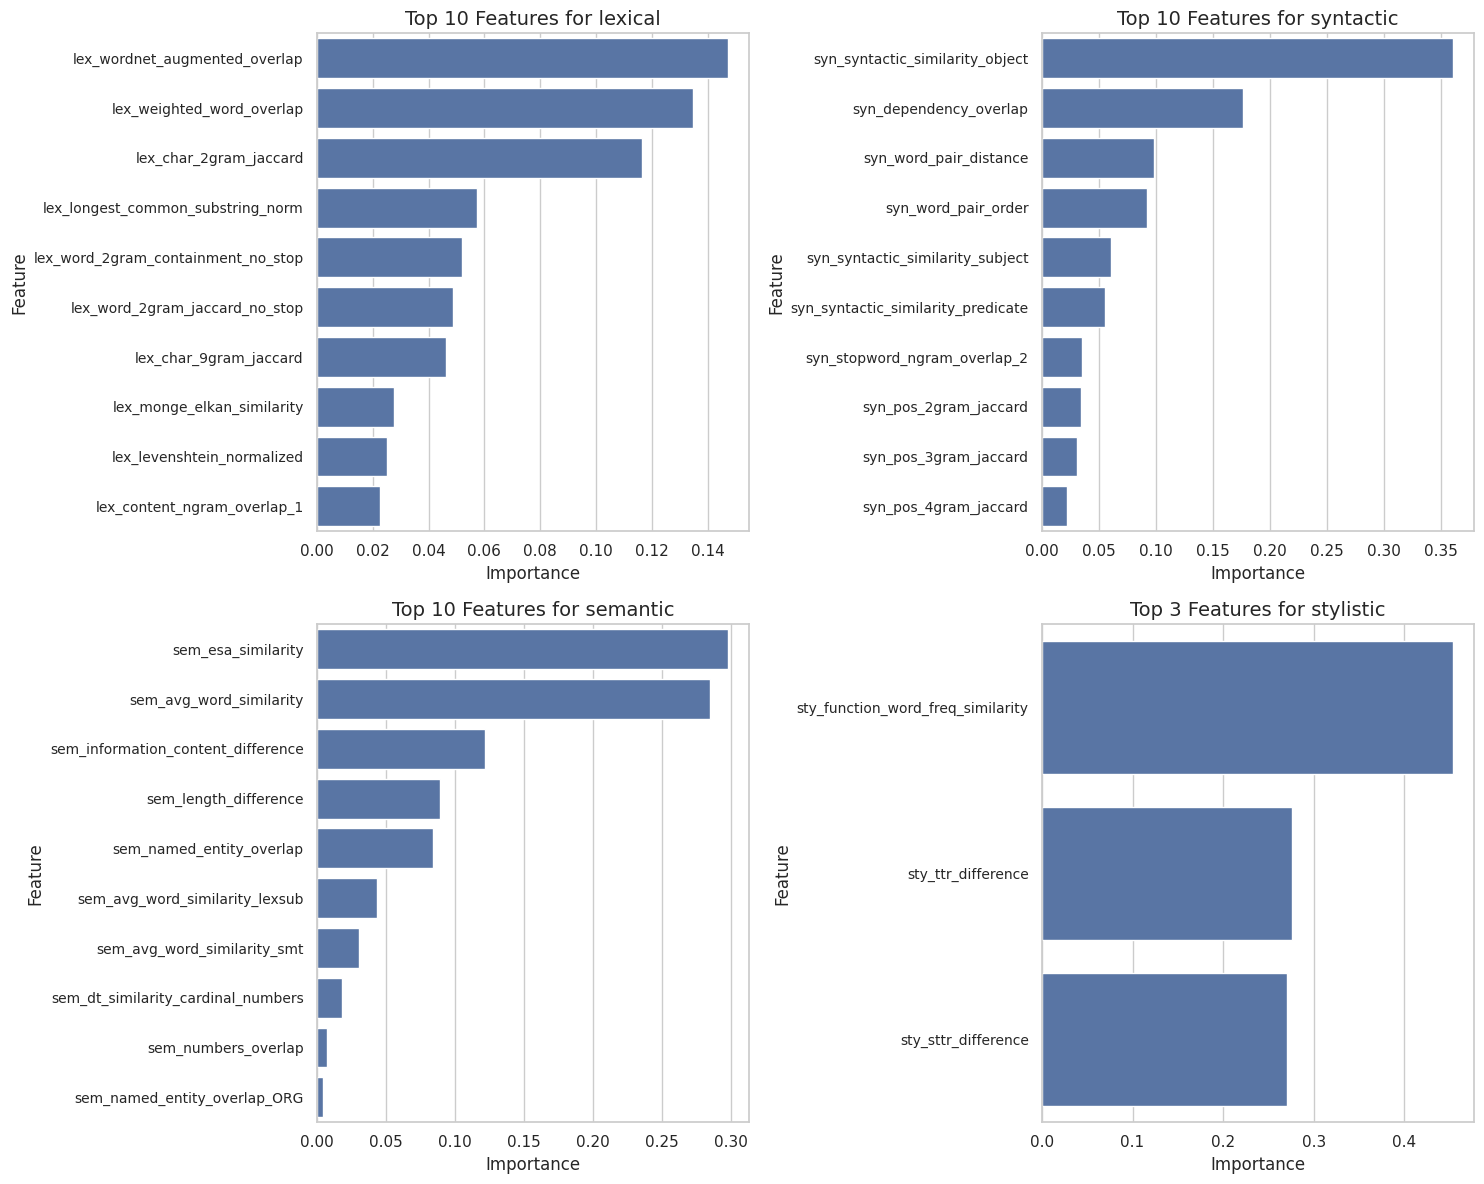

In [41]:
feature_sets_grid = ['lexical', 'syntactic', 'semantic', 'stylistic']
feature_importances_dict_grid = {}

for feature_set_name in feature_sets_grid:
    best_row = results_df[results_df['Feature_Set'] == feature_set_name] \
        .sort_values('Test_Pearson', ascending=False).iloc[0]
    best_model_name = best_row['Model_Name']
    best_model = load_best_model(feature_set_name, model_save_path)
    selected_features = get_selected_features(results_df, feature_set_name, best_model_name)
    feature_importances = get_feature_importances(best_model, selected_features)
    feature_importances_dict_grid[feature_set_name] = feature_importances
    print(f"len {feature_set_name}: {len(selected_features)}")
    
plot_top_features_grid(feature_importances_dict_grid, top_n=10)



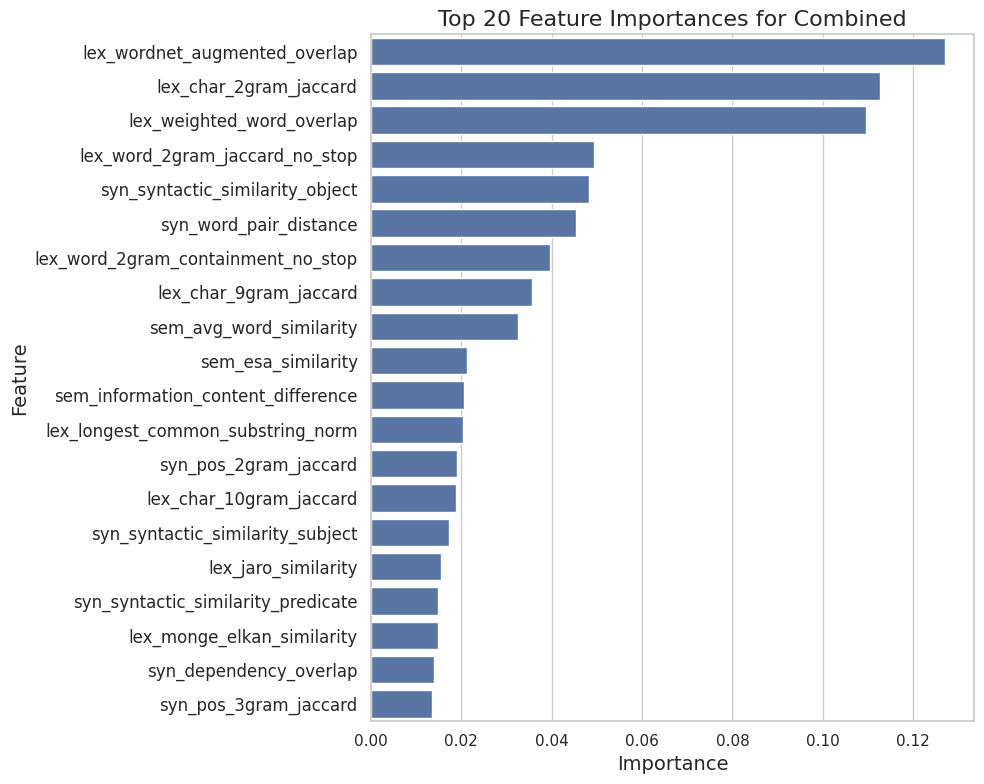

In [42]:
feature_set_name = 'combined'

best_row_combined = results_df[results_df['Feature_Set'] == feature_set_name] \
    .sort_values('Test_Pearson', ascending=False).iloc[0]
best_model_name_combined = best_row_combined['Model_Name']

best_model_combined = load_best_model(feature_set_name, model_save_path)
selected_features_combined = get_selected_features(results_df, feature_set_name, best_model_name_combined)
feature_importances_combined = get_feature_importances(best_model_combined, selected_features_combined)

plot_top_features(feature_importances_combined, 'Combined', top_n=20)

**Analysis:**

The lexical feature set heavily relies on word and character overlap to assess similarity; the highest importance scores are attributed to "lex_wordnet_augmented_overlap," "lex_weighted_word_overlap," and "lex_char_2gram_jaccard." WordNet augments word overlap by capturing deeper semantic relationships, while character n-gram Jaccard similarities assess surface-level similarities. The prominence of features like "lex_longest_common_substring_norm" and "lex_longest_common_subsequence_norm" further underscores the significance of shared sequences.

In the syntactic feature set, "syn_syntactic_similarity_object" has a remarkably high importance score, suggesting that the similarity of objects within sentence structures is crucial. Features like "syn_dependency_overlap" and "syn_word_pair_distance" highlight the importance of syntactic relationships and positional distances between words; the inclusion of part-of-speech n-gram Jaccard similarities indicates that patterns in grammatical structures contribute to the model's understanding of sentence similarity.

Within the semantic feature set, "sem_esa_similarity" and "sem_avg_word_similarity" are the most significant, utilizing semantic representations to capture the underlying meanings of sentences. The importance of "sem_information_content_difference" and "sem_length_difference" suggests that the amount of unique information and sentence length are also influential; named entity overlaps contribute to a lesser extent.

For the stylistic feature set, "sty_function_word_freq_similarity" stands out, highlighting that similarities in function word usage are highly indicative of sentence similarity from a stylistic perspective. "sty_ttr_difference" and "sty_sttr_difference" measure lexical diversity, suggesting that sentences with similar variety in word usage tend to be more similar.

In the combined feature set, the most important features are consistent with those in the individual models, with lexical overlap measures remaining highly influential. Syntactic features like "syn_syntactic_similarity_object" and "syn_word_pair_distance" are among the top features, indicating that when combined, syntactic information enhances the model's predictions. Semantic features such as "sem_avg_word_similarity" and "sem_esa_similarity" also contribute meaningfully; the combined model benefits from the integration of multiple linguistic levels, with lexical features providing a strong foundation, while syntactic and semantic features offer additional layers of understanding.

## 4.2 Per Dataset

Analyzing feature set: lexical


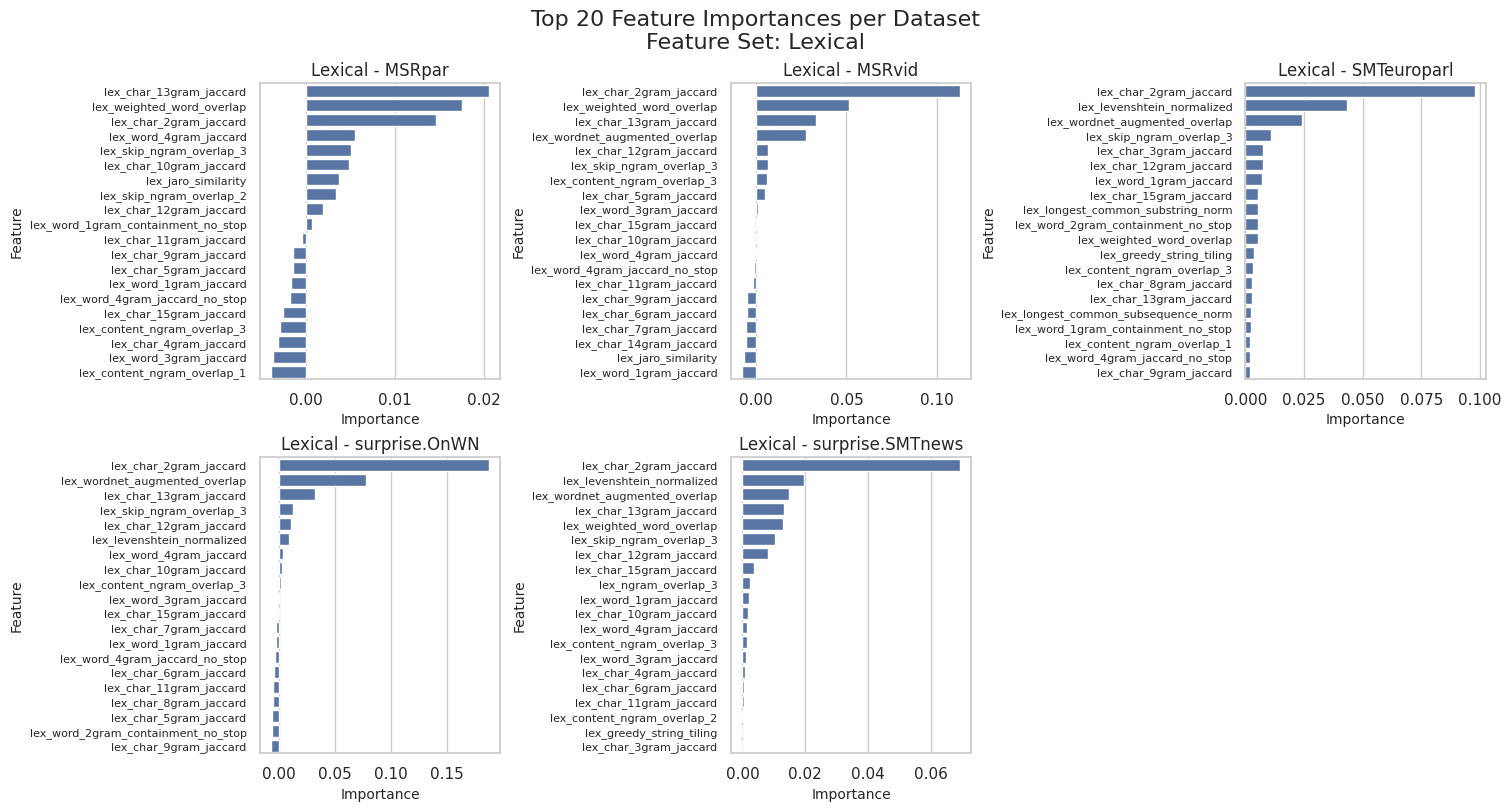

Analyzing feature set: syntactic


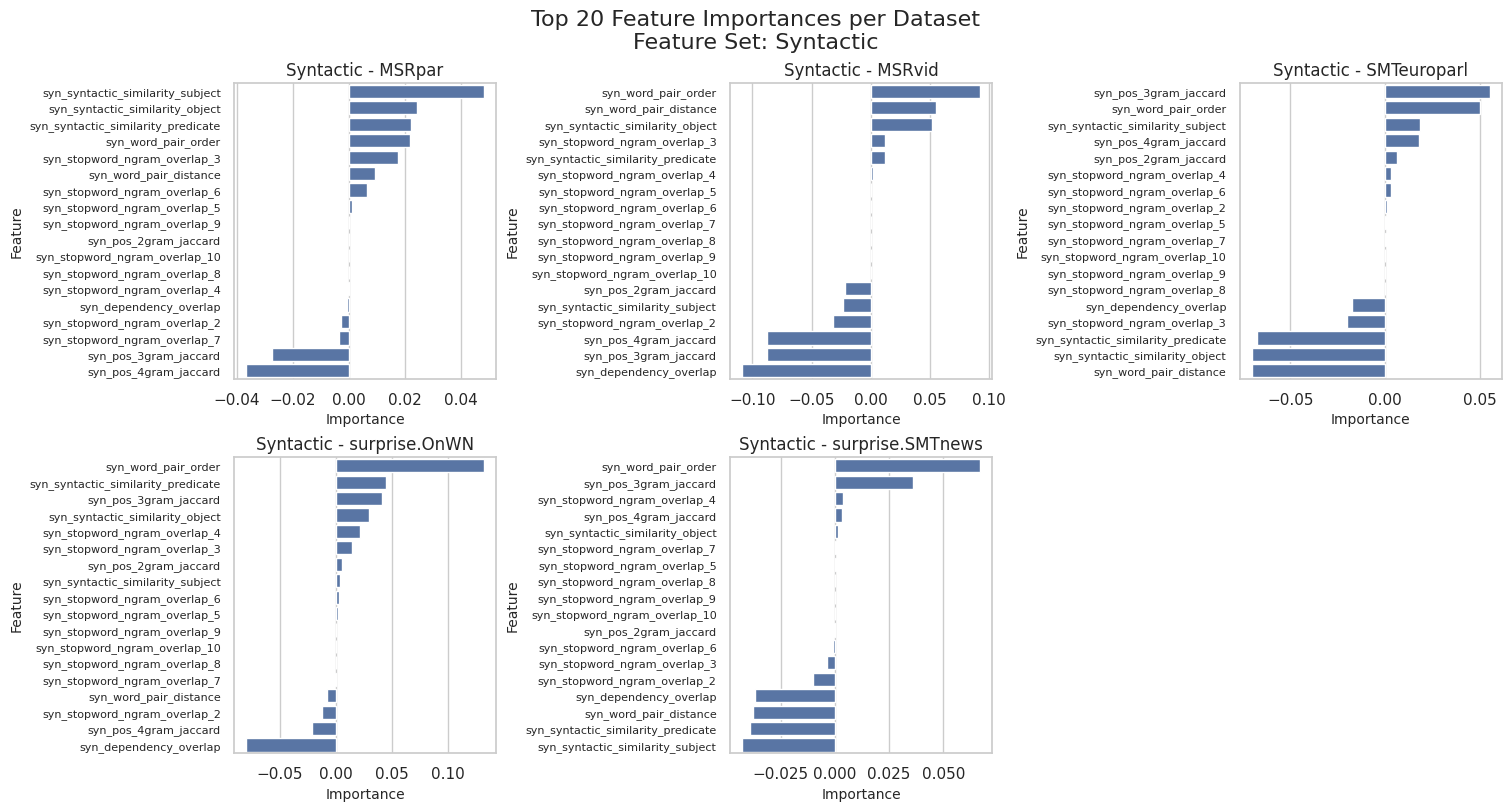

Analyzing feature set: semantic


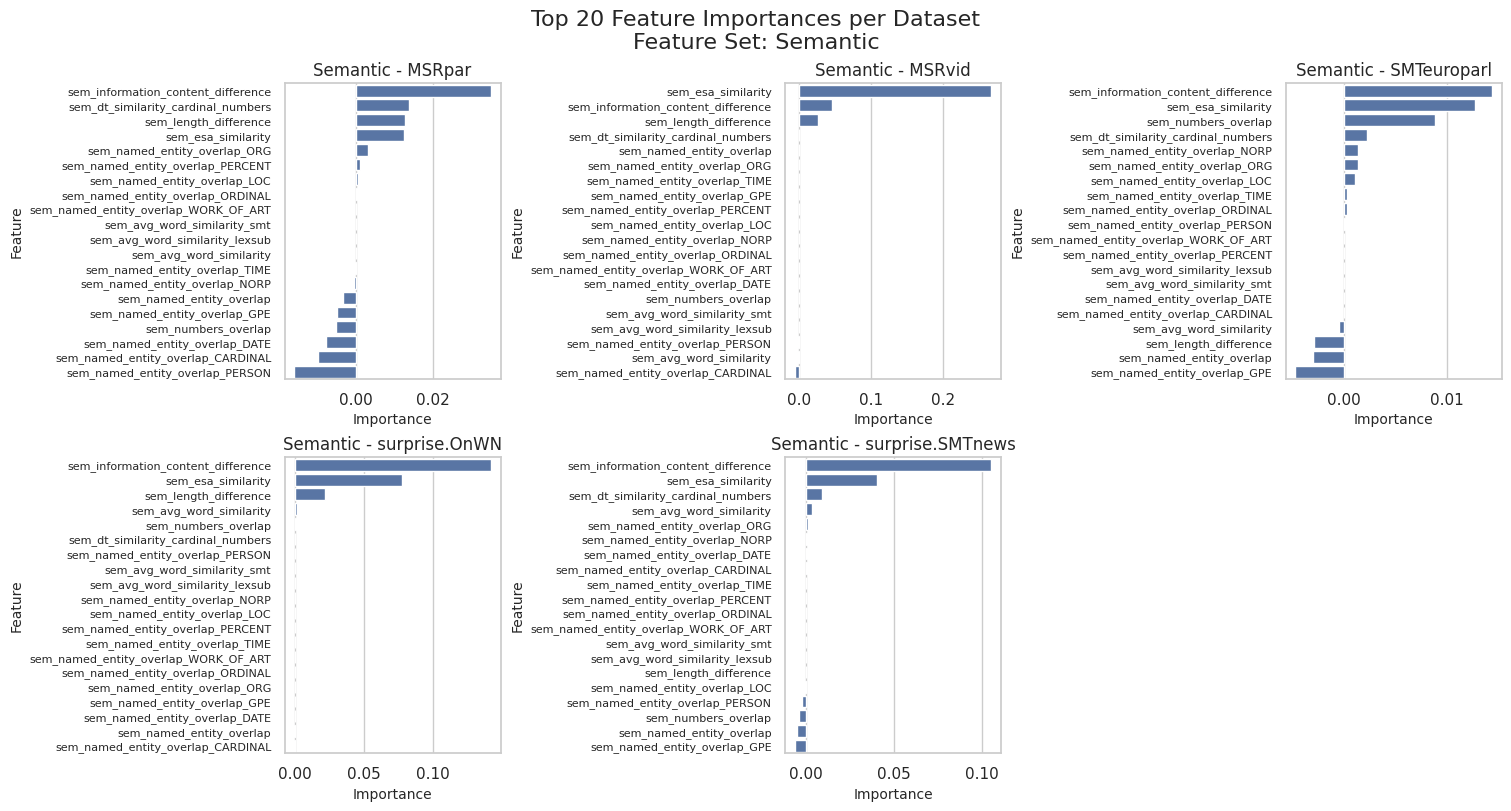

Analyzing feature set: stylistic


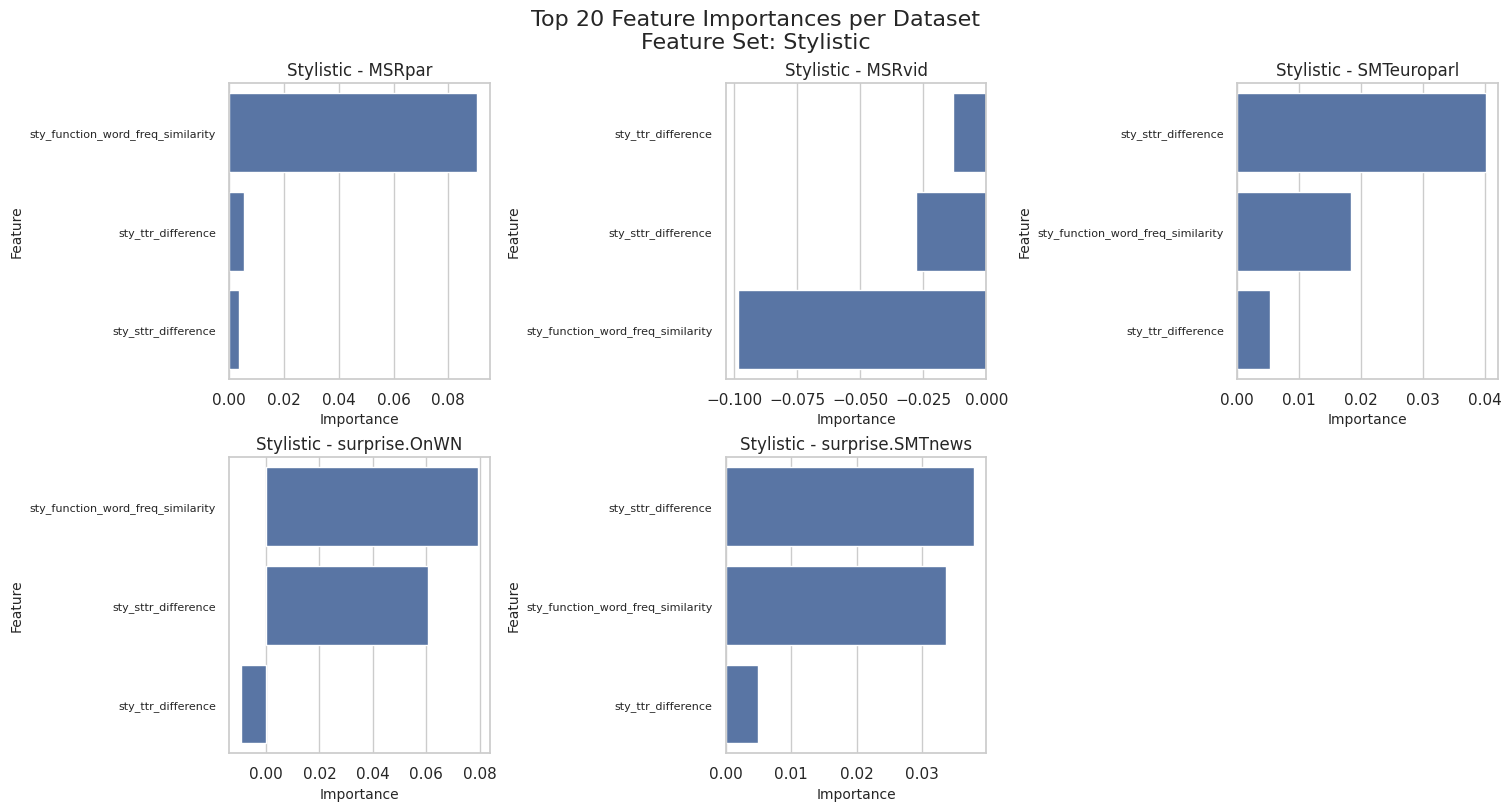

Analyzing feature set: combined


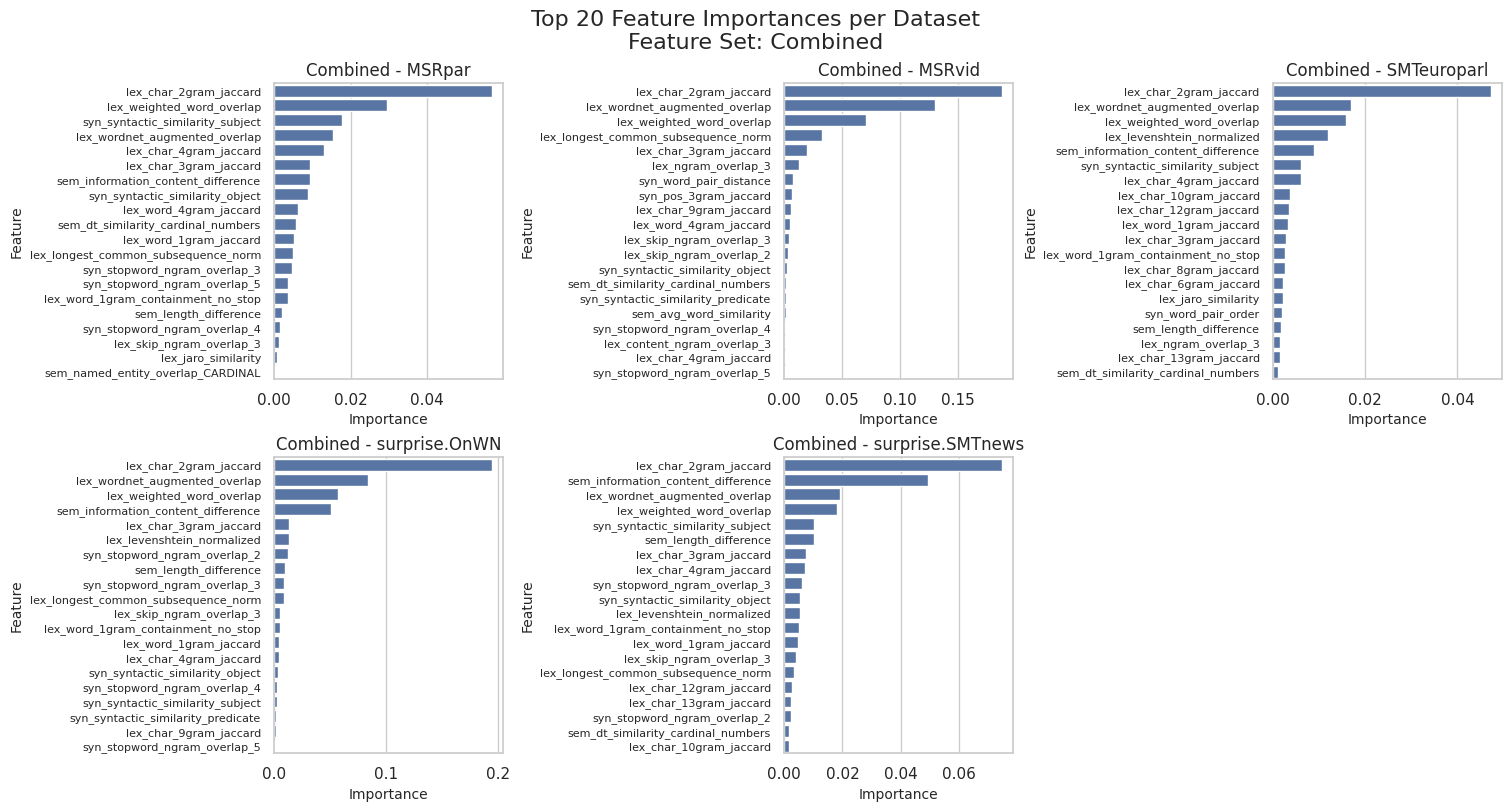

In [43]:
plot_full_analysis_feature_importance_per_dataset(results_df, train_features_df, test_features_df, model_save_path)

**Analysis:**

In the **lexical feature set**, the "lex_char_2gram_jaccard" consistently emerges as a top feature across all datasets, but its importance varies significantly. For instance, it has a high importance score in the MSRvid dataset (0.112787) and an even higher score in surprise.OnWN (0.187619), indicating that character-level bigram overlaps are highly indicative of semantic similarity in these datasets. Conversely, in MSRpar, its importance is much lower (0.014582), suggesting that character bigram overlaps contribute less to assessing similarity in that dataset. This variation could be attributed to the nature of the texts; MSRvid includes short video descriptions with high lexical overlap, making character-level similarities more impactful, whereas MSRpar consists of paraphrases with potentially more lexical variation.

Other lexical features such as "lex_weighted_word_overlap" and "lex_wordnet_augmented_overlap" also show differing levels of importance. In MSRvid and surprise.OnWN, "lex_wordnet_augmented_overlap" is significantly important (0.027888 and 0.077355, respectively), suggesting that semantic augmentation via WordNet is valuable in datasets dealing with definitions or descriptions where synonymy plays a key role. However, in MSRpar, this feature does not appear among the top contributors, possibly because paraphrases in that dataset may require deeper semantic understanding beyond direct lexical augmentation.



The **syntactic feature set** exhibits similar variations. The feature "syn_syntactic_similarity_object" is highly important in MSRpar (0.024400) and MSRvid (0.051614); in contrast, in SMTeuroparl and surprise.SMTnews, its importance diminishes or becomes negative, suggesting it is less relevant or even counterproductive, maybe them being translated texts or news articles, where syntactic structures may vary significantly due to translation differences or stylistic choices.

"Syn_word_pair_order" holds substantial importance in datasets like MSRvid (0.092610) and surprise.OnWN (0.132361), highlighting that the order of word pairs is a strong indicator of similarity in these cases. This might be because these datasets involve texts where word order conveys significant meaning, and maintaining word order is essential for preserving the original message. In contrast, its negative importance in SMTeuroparl and surprise.SMTnews indicates that strict adherence to word pair order may not correspond to higher similarity in these datasets, perhaps due to translation variations or paraphrasing that alters word sequences without changing the underlying meaning.



Within the **semantic feature set**, "sem_esa_similarity" and "sem_information_content_difference" are highly important in datasets like MSRvid and surprise.OnWN, with scores of 0.267449 and 0.142029, respectively. This suggests that in datasets involving descriptions or definitions, capturing the broader semantic content and the amount of unique information is very important. However, in MSRpar and SMTeuroparl, these features have lower importance or even negative values, indicating that broader semantic measures may be less effective in datasets comprising paraphrases or translations where specific semantic nuances are more critical.

Named entity overlap features demonstrate variable importance across datasets. For example, "sem_named_entity_overlap_ORG" has a positive importance in MSRpar (0.003115) and SMTeuroparl (0.001396), suggesting that overlapping organizational entities contribute to assessing similarity in these datasets that may involve formal texts or discussions about organizations. In contrast, these overlaps are negligible or negative in datasets like MSRvid and surprise.OnWN, where such entities may be less prevalent or relevant.



In the **stylistic feature set**, "sty_function_word_freq_similarity" shows positive importance in datasets like MSRpar (0.090610) and surprise.OnWN (0.079372), indicating that similarity in function word usage correlates with overall similarity in these datasets. However, in MSRvid, this feature has negative importance (-0.098421), suggesting that in short descriptive texts, function word frequency may not be a reliable indicator of similarity and could even mislead the model. This could be due to the brevity of the texts in MSRvid, where function words might not vary significantly or might be less informative compared to content words.



The **combined feature set** underscores the varying importance of features across datasets by integrating lexical, syntactic, and semantic features. In MSRvid and surprise.OnWN, lexical features like "lex_char_2gram_jaccard" and "lex_wordnet_augmented_overlap" dominate the top positions, reaffirming the significance of character-level overlaps and semantic augmentation in these datasets. In contrast, in MSRpar, syntactic features like "syn_syntactic_similarity_subject" and "syn_syntactic_similarity_object" appear among the top features, highlighting the importance of syntactic structure in paraphrase detection.

Moreover, semantic features like "sem_information_content_difference" hold considerable importance in surprise.OnWN (0.050545) and surprise.SMTnews (0.049421) within the combined model, suggesting that measuring the difference in informational content is crucial in datasets involving definitions and news texts, where the amount of information conveyed can vary significantly between sentences. Conversely, in MSRpar, this feature has a lower importance, indicating that informational content difference may not be as critical in paraphrased texts where the information is largely the same but expressed differently.

---
---


# 5. Error Analysis

In this final section of this project we analyse our predictions and our errors.

In [44]:
import pandas as pd
import numpy as np
from scripts.data_loader import load_data

results_csv_path        = 'results/model_results.csv'
model_save_path         = 'models'
train_features_csv_path = 'results/train_features.csv'
test_features_csv_path  = 'results/test_features.csv'

test_data = load_data('data', dataset_type='test')

results_df          = pd.read_csv(results_csv_path)
train_features_df   = pd.read_csv(train_features_csv_path)
test_features_df    = pd.read_csv(test_features_csv_path)

clip_threshold = 10 # IMPORTANT
train_features_df.fillna(0, inplace=True)
test_features_df.fillna(0, inplace=True)
train_features_df.update(train_features_df.select_dtypes(include=[np.number]).clip(upper=clip_threshold))
test_features_df.update(test_features_df.select_dtypes(include=[np.number]).clip(upper=clip_threshold))

feature_sets = ['lexical', 'syntactic', 'semantic', 'stylistic', 'combined']

from scripts.feature_analysis import (
    collect_predictions_and_errors,
    plot_error_distribution_grid,
    plot_true_vs_predicted_density,
    plot_combined_distribution_grid,
    get_hardest_failures
)

error_dict, y_true_dict, y_pred_dict, data_dict = collect_predictions_and_errors(results_df, test_features_df, model_save_path)


## 5.1 Error Distributions

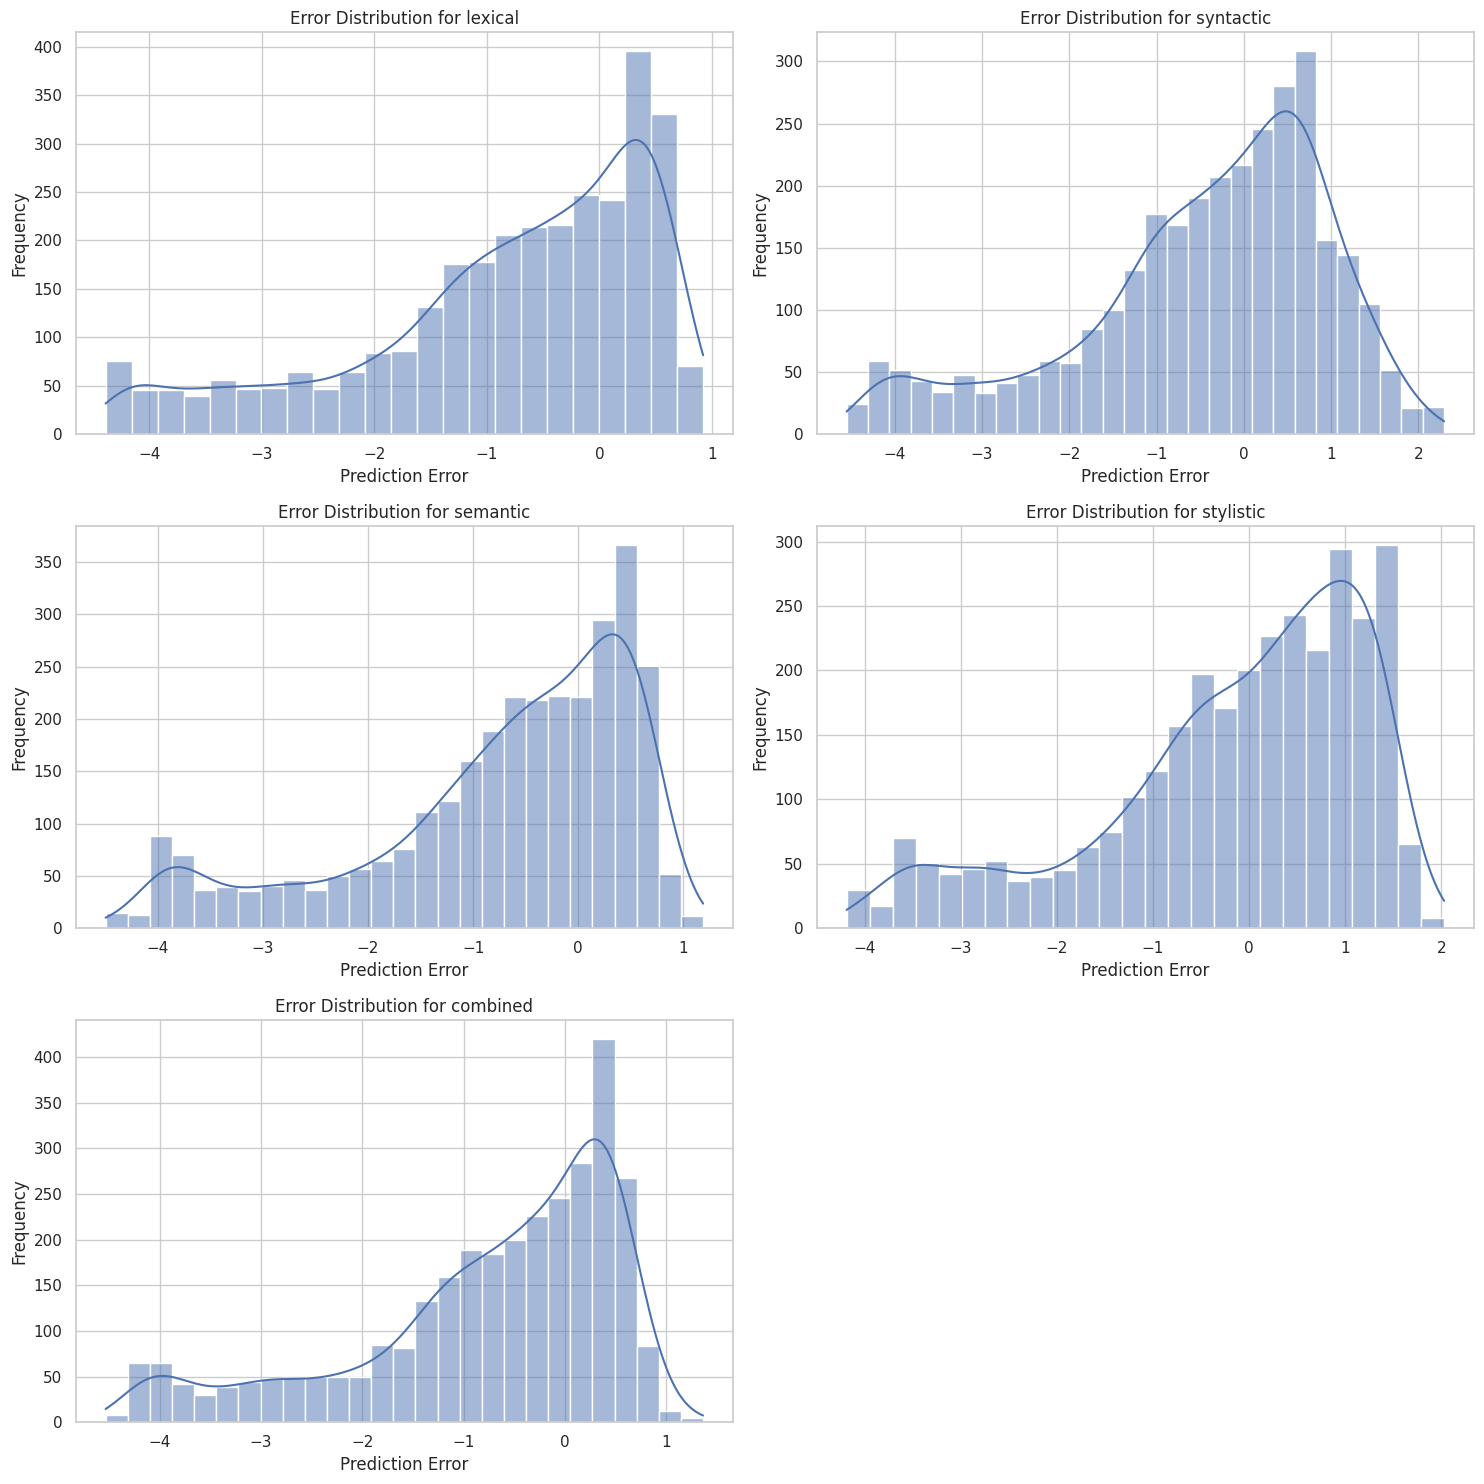

In [45]:
plot_error_distribution_grid(error_dict, feature_sets)

**Analysis:**

We always seem to be _overpedicting_; let's plot more visualisations to be clear

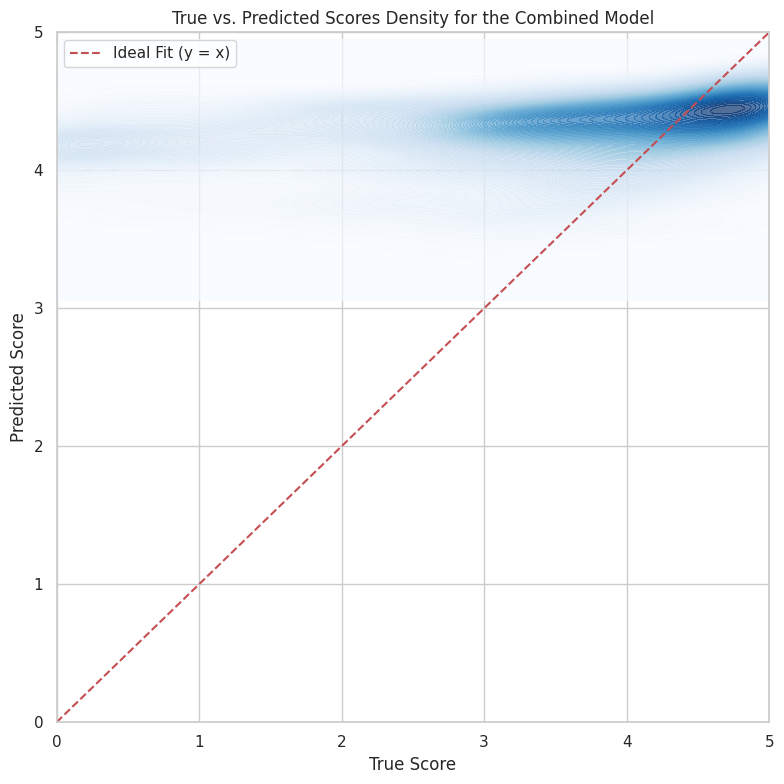

In [46]:
plot_true_vs_predicted_density(y_true_dict['combined'], y_pred_dict['combined'])

**Analysis:**

The horizontal lines seem to suggest our model always overpredicts over the target, when it should be something more like a diagonal line. We plot the distribution of our predictions, of the test, and of the train, to understand this:

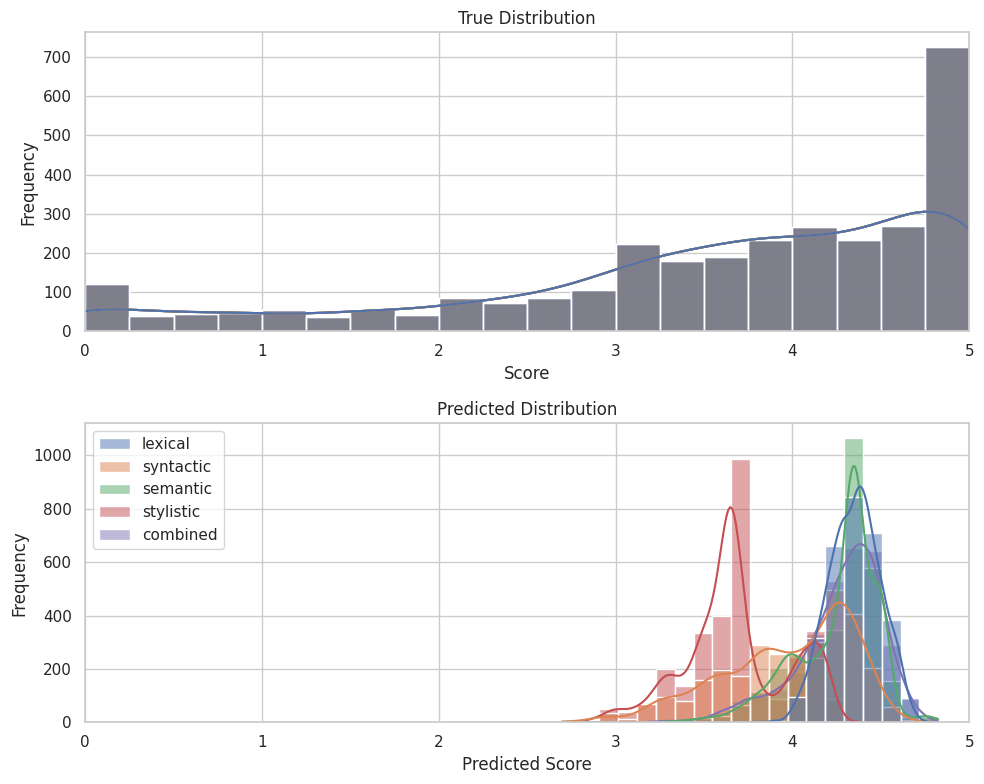

In [47]:
plot_combined_distribution_grid(y_true_dict, y_pred_dict)


**Overall Analysis:**

From the plots, we observe a clear tendency of the model to overpredict scores, particularly in the mid-to-high range, while significantly underestimating lower scores. This pattern is evident across all feature sets; it is clearly seen on the density plots of true versus predicted scores, where the true scores exhibit a broad distribution, but the predicted scores cluster unnaturally close to the upper end of the scale.

This becomes even more apparent when plotting their distributions individually: we observe that the true scores are distributed from 0 to 5, while our predictions seem to have no values below 3.

We believe this is due to using Pearson correlation as the metric to optimize (especially when performing grid search). Pearson measures the linear relationship between predicted and true scores; however, it does not penalize biases in the absolute scale of predictions as long as the relative ranking is preserved. This allows models to "game" the evaluation system by disproportionately predicting high scores, achieving deceptively strong correlations while failing to capture the true variance in the data. This issue is amplified in the context of surprise datasets, where the distribution of true scores may differ significantly from the training data; here, overpredicting can act as a form of hedging, minimizing errors at the expense of meaningful predictions.

Interestingly, this phenomenon mirrors strategies employed by other teams, such as UKP, during evaluations on surprise datasets; their paper explains that for the surprise datasets they resorted to predicting scores randomly between 4.5 and 5. This effectively exploited the evaluation system, as the gold standard distributions in those datasets were also skewed towards high scores.

## 5.2 Specific examples

We will finally visualise those cases where we missed the hardest, and try to understand why—other than the overpredicting issue.

In [48]:
for feature_set_name in feature_sets:
    print("="*80)
    print(f"Identifying hardest failures for feature set: {feature_set_name}")
    
    test_df_copy = test_features_df.copy()
    test_df_copy['predicted_score'] = y_pred_dict[feature_set_name]
    
    failures = get_hardest_failures(test_df_copy, test_data, y_true_col='score', y_pred_col='predicted_score', top_n=5)
    for dataset, df_failures in failures.items():
        print(f"Dataset: {dataset}")
        display(df_failures)


Identifying hardest failures for feature set: lexical
Dataset: MSRpar


,sentence1,sentence2,score,predicted_score,error
442,"One, Capt. Doug McDonald, remained hospitalize...","Her 20-year-old sister, Allyson, was severely ...",0.75,4.373467,3.623467
234,The broader Standard & Poor's 500 Index <.SPX>...,The technology-laced Nasdaq Composite Index wa...,0.80,4.270533,3.470533
1,The technology-laced Nasdaq Composite Index .I...,The broad Standard & Poor's 500 Index .SPX inc...,0.80,4.261843,3.461843
72,The technology-laced Nasdaq Composite Index <....,The broad Standard & Poor's 500 Index .SPX was...,0.80,4.227800,3.427800
590,"To reach John A. Dvorak, who covers Kansas, ca...","To reach Brad Cooper, Johnson County municipal...",1.00,4.423750,3.423750


Dataset: MSRvid


,sentence1,sentence2,score,predicted_score,error
1030,The man is riding a horse.,A woman is using a hoe.,0.0,4.387560,4.387560
1498,A badger is digging in the dirt.,A man is moving large rocks.,0.0,4.347446,4.347446
1227,An elderly woman is pouring oil into a frying ...,A tied man is putting into water.,0.0,4.335338,4.335338
1314,The animal is eating.,A woman is dancing.,0.0,4.323158,4.323158
1401,A woman is mincing some garlic.,A person is cleaning a disk.,0.0,4.303808,4.303808


Dataset: SMTeuroparl


,sentence1,sentence2,score,predicted_score,error
1795,That provision could open the door wide to arb...,This paves the way for the of the Rules of Pro...,1.50,4.264460,2.764460
1875,We often pontificate here about being the repr...,We are often here to represent the European ci...,2.75,4.421241,1.671241
1892,"Thank you, Commissioner.","Thank you, Mister the Police chief.",2.50,4.127164,1.627164
1641,"Mr President, the Cashman report can be summar...","Mr President, the report Mr Cashman's can be s...",3.00,4.468197,1.468197
1898,"Unfortunately, others separate on the basis of...",D ' others part unfortunately in reason d ' a ...,3.00,4.402593,1.402593


Dataset: surprise.OnWN


,sentence1,sentence2,score,predicted_score,error
1993,the price of a good or service,an assertion that someone is guilty of a fault...,0.0,4.263385,4.263385
2198,connect with; reach a target or goal,"perceive with the senses quickly, suddenly, or...",0.0,4.224447,4.224447
2123,a unit cost of something,a single chance or instance.,0.0,4.220496,4.220496
2047,"move to a new location, state, or situation",cause (a computer) to execute a single command.,0.0,4.192574,4.192574
1997,(Cause to) smell bad.,be extremely bad in quality or in one's perfor...,0.0,4.169550,4.169550


Dataset: surprise.SMTnews


,sentence1,sentence2,score,predicted_score,error
2845,Being a Muslim and being an Islamist are not t...,It is necessary to are two different things.,0.25,4.354181,4.104181
2928,"Gays and other ""modern"" practices are rejected...","The catch and other practices, because.",0.25,4.228480,3.978480
2755,What we are witnessing today is a shift from a...,In the absence of a change of associations.,0.50,4.378934,3.878934
2727,"They are ignorant, poor, and sick.",They are for the moment.,0.50,3.914538,3.414538
3105,Will it give us the right to divorce the husba...,A couple who have left?,1.00,4.184984,3.184984


Identifying hardest failures for feature set: syntactic
Dataset: MSRpar


,sentence1,sentence2,score,predicted_score,error
707,"Shares of USA Interactive rose $2.28, or 7 per...","Shares of LendingTree rose $6.03, or 41 percen...",1.0,4.466519,3.466519
510,The S&P/TSX composite rose 87.74 points on the...,"On the week, the Dow Jones industrial average ...",1.0,4.356628,3.356628
682,Sterling was down 0.8 percent against the doll...,The dollar rose 0.15 percent against the Japan...,0.8,4.050911,3.250911
169,The SIA says the DRAM market is expected to gr...,The Americas market will decline 2.1 percent t...,1.2,4.404803,3.204803
45,"Earlier this month, RIM had said it expected t...",Excluding legal fees and other charges it expe...,1.2,4.371727,3.171727


Dataset: MSRvid


,sentence1,sentence2,score,predicted_score,error
1271,A man is opening a box and taking out paper.,A woman is peeling a potato.,0.0,4.551640,4.551640
1386,A cat is walking around a house.,A woman is peeling potato.,0.0,4.525825,4.525825
1287,A man is playing guitar.,A woman is slicing up some pork.,0.0,4.514824,4.514824
1325,A woman is chopping onion.,A man is doing a card trick.,0.0,4.514824,4.514824
1223,A man is playing a flute.,A dog is barking at a fly.,0.0,4.454754,4.454754


Dataset: SMTeuroparl


,sentence1,sentence2,score,predicted_score,error
1795,That provision could open the door wide to arb...,This paves the way for the of the Rules of Pro...,1.5,3.892292,2.392292
1515,Tunisia,Tunisia,5.0,2.919150,2.080850
1550,Tunisia,Tunisia,5.0,2.919150,2.080850
1577,Tunisia,Tunisia,5.0,2.919150,2.080850
1585,Tunisia,Tunisia,5.0,2.919150,2.080850


Dataset: surprise.OnWN


,sentence1,sentence2,score,predicted_score,error
2047,"move to a new location, state, or situation",cause (a computer) to execute a single command.,0.0,3.906417,3.906417
1993,the price of a good or service,an assertion that someone is guilty of a fault...,0.0,3.707903,3.707903
2198,connect with; reach a target or goal,"perceive with the senses quickly, suddenly, or...",0.0,3.649472,3.649472
1997,(Cause to) smell bad.,be extremely bad in quality or in one's perfor...,0.0,3.437160,3.437160
2132,"area of damaged, cut tissue on a living body",a casualty to military personnel resulting fro...,0.5,3.693802,3.193802


Dataset: surprise.SMTnews


,sentence1,sentence2,score,predicted_score,error
2928,"Gays and other ""modern"" practices are rejected...","The catch and other practices, because.",0.25,3.445903,3.195903
2845,Being a Muslim and being an Islamist are not t...,It is necessary to are two different things.,0.25,3.403433,3.153433
2755,What we are witnessing today is a shift from a...,In the absence of a change of associations.,0.50,3.616992,3.116992
3105,Will it give us the right to divorce the husba...,A couple who have left?,1.00,4.012677,3.012677
2727,"They are ignorant, poor, and sick.",They are for the moment.,0.50,3.238323,2.738323


Identifying hardest failures for feature set: semantic
Dataset: MSRpar


,sentence1,sentence2,score,predicted_score,error
442,"One, Capt. Doug McDonald, remained hospitalize...","Her 20-year-old sister, Allyson, was severely ...",0.75,4.443296,3.693296
682,Sterling was down 0.8 percent against the doll...,The dollar rose 0.15 percent against the Japan...,0.80,4.491788,3.691788
368,The broader Standard & Poor's 500 Index .SPX a...,The Nasdaq Composite Index .IXIC was off 6.52 ...,0.80,4.330711,3.530711
234,The broader Standard & Poor's 500 Index <.SPX>...,The technology-laced Nasdaq Composite Index wa...,0.80,4.287440,3.487440
538,The technology-laced Nasdaq Composite Index <....,The broader Standard & Poor's 500 Index .SPX w...,1.00,4.436670,3.436670


Dataset: MSRvid


,sentence1,sentence2,score,predicted_score,error
1498,A badger is digging in the dirt.,A man is moving large rocks.,0.0,4.496172,4.496172
1161,A man is holding a leaf.,A monkey is fighting a man.,0.0,4.496115,4.496115
1484,A woman is spreading mustard on a bread roll.,A kitten is playing with a woman's finger.,0.0,4.485731,4.485731
1301,A woman is putting her baby in a waste bin.,The woman is poking holes in the potato.,0.0,4.426546,4.426546
1409,A man lays on the ground and aims a rifle.,A man is spreading butter on a tortilla.,0.0,4.399112,4.399112


Dataset: SMTeuroparl


,sentence1,sentence2,score,predicted_score,error
1795,That provision could open the door wide to arb...,This paves the way for the of the Rules of Pro...,1.50,4.347803,2.847803
1875,We often pontificate here about being the repr...,We are often here to represent the European ci...,2.75,4.376343,1.626343
1641,"Mr President, the Cashman report can be summar...","Mr President, the report Mr Cashman's can be s...",3.00,4.428157,1.428157
1657,Van Orden Report (A5-0241/2000),Report Horsebox Orden (A5-0241 / 2000),3.00,4.344569,1.344569
1562,I am one of those Members who attends sittings...,I am part of Members who are not properly pres...,3.00,4.340721,1.340721


Dataset: surprise.OnWN


,sentence1,sentence2,score,predicted_score,error
2198,connect with; reach a target or goal,"perceive with the senses quickly, suddenly, or...",0.0,4.302908,4.302908
2047,"move to a new location, state, or situation",cause (a computer) to execute a single command.,0.0,3.991579,3.991579
2123,a unit cost of something,a single chance or instance.,0.0,3.981309,3.981309
2062,(cause to) stop speaking or bring about silence,move so that an opening or passage is obstruct...,0.5,4.368173,3.868173
2208,deliver a formal talk or reprimand at length,censure severely or angrily.,0.5,4.359942,3.859942


Dataset: surprise.SMTnews


,sentence1,sentence2,score,predicted_score,error
2845,Being a Muslim and being an Islamist are not t...,It is necessary to are two different things.,0.25,4.029497,3.779497
2928,"Gays and other ""modern"" practices are rejected...","The catch and other practices, because.",0.25,3.941933,3.691933
2755,What we are witnessing today is a shift from a...,In the absence of a change of associations.,0.50,3.483538,2.983538
2727,"They are ignorant, poor, and sick.",They are for the moment.,0.50,3.278555,2.778555
3105,Will it give us the right to divorce the husba...,A couple who have left?,1.00,3.713160,2.713160


Identifying hardest failures for feature set: stylistic
Dataset: MSRpar


,sentence1,sentence2,score,predicted_score,error
590,"To reach John A. Dvorak, who covers Kansas, ca...","To reach Brad Cooper, Johnson County municipal...",1.0,4.084086,3.084086
510,The S&P/TSX composite rose 87.74 points on the...,"On the week, the Dow Jones industrial average ...",1.0,4.065791,3.065791
83,Analysts expected earnings of 27 cents a share...,Hewlett-Packard is putting in for a second-qua...,1.2,4.173531,2.973531
234,The broader Standard & Poor's 500 Index <.SPX>...,The technology-laced Nasdaq Composite Index wa...,0.8,3.698319,2.898319
1,The technology-laced Nasdaq Composite Index .I...,The broad Standard & Poor's 500 Index .SPX inc...,0.8,3.671694,2.871694


Dataset: MSRvid


,sentence1,sentence2,score,predicted_score,error
1409,A man lays on the ground and aims a rifle.,A man is spreading butter on a tortilla.,0.0,4.186155,4.186155
1456,A person is putting salt and pepper on a piece...,A youngster is sitting on a piano.,0.0,4.183199,4.183199
1479,A man is buttering a piece of bread.,A slow loris hanging on a cord.,0.0,4.179971,4.179971
1481,A cat is licking himself.,A man is slicing a white onion with a mandolin...,0.0,4.147120,4.147120
1189,A woman is water skiing on a lake.,A man is playing a flute.,0.0,4.124456,4.124456


Dataset: SMTeuroparl


,sentence1,sentence2,score,predicted_score,error
1795,That provision could open the door wide to arb...,This paves the way for the of the Rules of Pro...,1.50,3.759610,2.259610
1573,"Consumers will lose out, employees will lose o...","The users are the losers, employees, and Europ...",4.75,2.935508,1.814492
1719,There must be a balance as a whole.,The unit must be in balance.,4.75,2.991790,1.758210
1816,"Mr President, the Cashman report can be summar...","Mr President, the Cashman report can be summar...",5.00,3.249119,1.750881
1609,"Selective aid, such as market support and a gr...",The occasional aid as the support of the marke...,4.50,2.789566,1.710434


Dataset: surprise.OnWN


,sentence1,sentence2,score,predicted_score,error
1993,the price of a good or service,an assertion that someone is guilty of a fault...,0.0,3.754228,3.754228
2047,"move to a new location, state, or situation",cause (a computer) to execute a single command.,0.0,3.706680,3.706680
2198,connect with; reach a target or goal,"perceive with the senses quickly, suddenly, or...",0.0,3.579245,3.579245
2123,a unit cost of something,a single chance or instance.,0.0,3.504823,3.504823
2121,a portion or percentage of a whole,the part played by a person in bringing about ...,0.5,3.994499,3.494499


Dataset: surprise.SMTnews


,sentence1,sentence2,score,predicted_score,error
2928,"Gays and other ""modern"" practices are rejected...","The catch and other practices, because.",0.25,3.504823,3.254823
2845,Being a Muslim and being an Islamist are not t...,It is necessary to are two different things.,0.25,3.322100,3.072100
2755,What we are witnessing today is a shift from a...,In the absence of a change of associations.,0.50,3.340507,2.840507
2727,"They are ignorant, poor, and sick.",They are for the moment.,0.50,3.337712,2.837712
3105,Will it give us the right to divorce the husba...,A couple who have left?,1.00,3.110472,2.110472


Identifying hardest failures for feature set: combined
Dataset: MSRpar


,sentence1,sentence2,score,predicted_score,error
442,"One, Capt. Doug McDonald, remained hospitalize...","Her 20-year-old sister, Allyson, was severely ...",0.750,4.156708,3.406708
72,The technology-laced Nasdaq Composite Index <....,The broad Standard & Poor's 500 Index .SPX was...,0.800,4.090257,3.290257
1,The technology-laced Nasdaq Composite Index .I...,The broad Standard & Poor's 500 Index .SPX inc...,0.800,4.064380,3.264380
682,Sterling was down 0.8 percent against the doll...,The dollar rose 0.15 percent against the Japan...,0.800,4.062459,3.262459
400,The broader Standard & Poor's 500 Index .SPX g...,The technology-laced Nasdaq Composite Index <....,0.944,4.106508,3.162508


Dataset: MSRvid


,sentence1,sentence2,score,predicted_score,error
1030,The man is riding a horse.,A woman is using a hoe.,0.0,4.533448,4.533448
1044,Someone is feeding a animal.,Someone is playing a piano.,0.0,4.522865,4.522865
1072,A man is shooting a gun.,A man is spitting.,0.0,4.356249,4.356249
1101,A cat is licking a sucker.,A woman is slicing cucumber.,0.0,4.351904,4.351904
1159,A woman is taking a shower.,A man is riding a white horse.,0.0,4.351220,4.351220


Dataset: SMTeuroparl


,sentence1,sentence2,score,predicted_score,error
1795,That provision could open the door wide to arb...,This paves the way for the of the Rules of Pro...,1.50,3.792794,2.292794
1875,We often pontificate here about being the repr...,We are often here to represent the European ci...,2.75,4.371335,1.621335
1898,"Unfortunately, others separate on the basis of...",D ' others part unfortunately in reason d ' a ...,3.00,4.490657,1.490657
1641,"Mr President, the Cashman report can be summar...","Mr President, the report Mr Cashman's can be s...",3.00,4.435794,1.435794
1935,"The standards are scarcely comparable, let alo...","The rules are comparable only good, let alone.",3.00,4.318337,1.318337


Dataset: surprise.OnWN


,sentence1,sentence2,score,predicted_score,error
2047,"move to a new location, state, or situation",cause (a computer) to execute a single command.,0.0,3.931384,3.931384
1997,(Cause to) smell bad.,be extremely bad in quality or in one's perfor...,0.0,3.919382,3.919382
1993,the price of a good or service,an assertion that someone is guilty of a fault...,0.0,3.790080,3.790080
2198,connect with; reach a target or goal,"perceive with the senses quickly, suddenly, or...",0.0,3.716933,3.716933
2132,"area of damaged, cut tissue on a living body",a casualty to military personnel resulting fro...,0.5,3.988379,3.488379


Dataset: surprise.SMTnews


,sentence1,sentence2,score,predicted_score,error
2845,Being a Muslim and being an Islamist are not t...,It is necessary to are two different things.,0.25,4.199492,3.949492
2928,"Gays and other ""modern"" practices are rejected...","The catch and other practices, because.",0.25,3.656247,3.406247
2755,What we are witnessing today is a shift from a...,In the absence of a change of associations.,0.50,3.854385,3.354385
2727,"They are ignorant, poor, and sick.",They are for the moment.,0.50,3.447646,2.947646
3105,Will it give us the right to divorce the husba...,A couple who have left?,1.00,3.926205,2.926205


**Analysis**

In the lexical feature set, the model often predicted high similarity scores for sentence pairs that were actually dissimilar. For example, in the MSRvid dataset, sentence pairs like "The man is riding a horse." and "A woman is using a hoe." have no meaningful lexical overlap; however, the model predicted a similarity score of 4.38 when the true score was 0. This suggests that the model relied heavily on superficial lexical features—such as word length or common stopwords—leading to overestimations when true lexical overlap was minimal.

Similarly, in the syntactic feature set, the model overpredicted similarity for sentences with similar syntactic structures but different meanings. In MSRpar, sentences like "Shares of USA Interactive rose..." and "Shares of LendingTree rose..." share syntactic patterns but refer to different entities; the model assigned high similarity scores due to the matching structure, overlooking semantic differences.

In the semantic feature set, overpredictions occurred when semantic features failed to capture true meaning differences. In the surprise.OnWN dataset, definitions like "the price of a good or service" and "an assertion that someone is guilty of a fault" are semantically unrelated; yet, the model predicted high similarity scores, possibly due to shared abstract vocabulary or insufficient semantic disambiguation.

The stylistic feature set showed overpredictions where stylistic similarities did not correspond to semantic ones. For instance, in MSRpar, sentences starting with "To reach [name], who covers..." had similar styles but different contents; the model overpredicted their similarity, indicating that stylistic features alone are insufficient for capturing semantic equivalence.

In the combined feature set, we expected better performance due to the integration of all features; however, the hardest failures reveal that overprediction persisted. In MSRvid, sentence pairs like "The man is riding a horse." and "A woman is using a hoe." were still assigned high similarity scores (e.g., 4.53) when the true score was 0. This suggests that combining features did not fully mitigate the reliance on superficial similarities; the model continued to overpredict when multiple features reinforced an erroneous assessment of similarity.

In the surprise.OnWN dataset, pairs like "move to a new location, state, or situation" and "cause (a computer) to execute a single command" were overpredicted in similarity; despite shared words like "move," their meanings are distinct. Even with combined features, the model failed to capture these semantic nuances, indicating limitations in our approach.

---
---


# 6. Conclusion and Future Work
In this project, we addressed the task of Semantic Textual Similarity (STS) by implementing a comprehensive range of features inspired by the UKP and TakeLab teams from SemEval 2012 Task 6. Our goal was to evaluate how different linguistic dimensions—lexical, syntactic, semantic, and stylistic—contribute to predicting the semantic similarity between sentence pairs.

Our combined feature set, utilizing a Gradient Boosting Regressor, achieved a Pearson correlation of 0.7634 on the test set, placing us within the top 10 in a simulated ranking based on the official results. Notably, we attained the highest mean rank, indicating consistent performance across all datasets.

Lexical features emerged as the most influential, especially in datasets with high lexical overlap like MSRvid; features such as character n-gram Jaccard similarity, weighted word overlap, and WordNet-augmented overlaps were critical in capturing surface-level similarities. Syntactic features contributed significantly in datasets with complex sentence structures, while semantic features particularly helped in datasets where wording differed but underlying concepts were similar, such as surprise.SMTnews. Stylistic features, however, consistently showed low or even negative correlations with the similarity scores, suggesting they are not strong predictors in this context.

Combining features from all dimensions led to the best overall performance, demonstrating that while lexical features provide a strong foundation, incorporating syntactic and semantic nuances enriches the model's understanding. Different datasets emphasized different features: MSRvid benefited most from lexical features due to its short, descriptive sentences with significant word overlap; MSRpar required syntactic features because of varied paraphrasing and complex structures; surprise.OnWN highlighted the value of semantic features due to nuanced definitions and varied writing styles.

Despite these successes, we faced challenges. Resource constraints limited some feature implementations; computational limitations led to approximations or simplifications, potentially impacting effectiveness. Tool differences may have affected performance, as we used readily available libraries that might not match the specialized tools employed by the original teams. Additionally, relying solely on Pearson correlation as the evaluation metric may have encouraged models to overpredict similarity scores, clustering predictions towards the higher end of the scale and underestimating lower scores. This bias could stem from Pearson's focus on relative rankings without penalizing consistent overestimations.

Along the same lines, our error analysis, particularly of the hardest failures, revealed that our models tended to overpredict similarity scores for sentence pairs that shared superficial features but were semantically unrelated. For instance, sentences with similar lengths, shared function words, or matching syntactic structures were often assigned high similarity scores despite differing meanings. This indicates that the models heavily relied on surface-level features captured by our implementations. Moreover, even with the combined feature set, the models struggled to disambiguate sentences that shared lexical or syntactic features but differed semantically. The integration of multiple feature types did not fully mitigate the reliance on superficial similarities. 

For future work, refining feature implementations—enhancing complex features like full-scale ESA models and more comprehensive skip n-grams—could improve performance. Addressing the overprediction tendency by adjusting evaluation metrics or employing calibration techniques could lead to more balanced predictions; investigating alternative stylistic measures might uncover stylistic features that contribute meaningfully. We also suggest analysing the values of specific features for the hardest errors, as that would help identify what features are "tricking" our model.